In [1]:
%load_ext autoreload
%autoreload 2

In [61]:
import csv
import numpy
import os

In [3]:
import sys

In [5]:
sys.path.append('/home/grimur/git/nplinker/nplinker/prototype')

In [6]:
from nplinker import nplinker
from nplinker import logconfig
logconfig.LogConfig.setLogLevel('DEBUG')

In [7]:
nplinker_data_path = '/home/grimur/data-crusemann/nplinker_crusemann_20200131/crusemann_new.toml'
gnps_spectrum_file = "/home/grimur/iokr_verify_data/crusemann/extracted/MSV000078836/clusterinfosummarygroup_attributes_withIDs_withcomponentID/b270f7e260f34e808ead3f642784b672.tsv"


In [8]:
npl = nplinker.NPLinker(nplinker_data_path)
npl.load_data()

15:50:38 [DEBUG] config.py:71, Parsing default config file: /home/grimur/.config/nplinker/nplinker.toml
15:50:38 [DEBUG] config.py:74, Loading user config /home/grimur/data-crusemann/nplinker_crusemann_20200131/crusemann_new.toml
15:50:38 [INFO] config.py:106, Loading from local data in directory /home/grimur/data-crusemann/nplinker_crusemann_26112019
15:50:38 [DEBUG] loader.py:129, DatasetLoader(/home/grimur/data-crusemann/nplinker_crusemann_26112019, , False)
15:50:38 [DEBUG] nplinker.py:119, Enabled scoring method: metcalf
15:50:38 [DEBUG] nplinker.py:119, Enabled scoring method: testscore
15:50:38 [DEBUG] nplinker.py:119, Enabled scoring method: rosetta
15:50:38 [DEBUG] nplinker.py:240, load_data (normal case, full load, met_only=False)
15:50:38 [WARNING] loader.py:31, WARNING: unable to find extra_nodes_file in path "/home/grimur/data-crusemann/nplinker_crusemann_26112019/quantification_table_reformatted/*.csv"
15:50:38 [WARNING] loader.py:31, WARNING: unable to find metadata_tabl

15:50:39 [WARNING] metabolomics.py:517, Unknown strain: 38a.mzXML for cluster index 44972
15:50:39 [WARNING] metabolomics.py:517, Unknown strain: 5a.mzXML for cluster index 116143
15:50:39 [WARNING] metabolomics.py:517, Unknown strain: 6a.mzXML for cluster index 80280
15:50:39 [WARNING] metabolomics.py:517, Unknown strain: 40b.mzXML for cluster index 121459
15:50:39 [WARNING] metabolomics.py:517, Unknown strain: 42b.mzXML for cluster index 95477
15:50:39 [WARNING] metabolomics.py:517, Unknown strain: S801-3-EA.mzXML for cluster index 13340
15:50:39 [WARNING] metabolomics.py:517, Unknown strain: H643-3-EA.mzXML for cluster index 13340
15:50:39 [WARNING] metabolomics.py:517, Unknown strain: 26c.mzXML for cluster index 58621
15:50:39 [WARNING] metabolomics.py:517, Unknown strain: 35c.mzXML for cluster index 58621
15:50:39 [WARNING] metabolomics.py:517, Unknown strain: 28a.mzXML for cluster index 58621
15:50:39 [WARNING] metabolomics.py:517, Unknown strain: 29a.mzXML for cluster index 5911

True

In [62]:
spectra_to_strains = {}
with open(gnps_spectrum_file, 'r') as f:
    r = csv.reader(f, delimiter="\t")
    header = next(r)
    id_column = header.index('cluster index')
    strain_columns = [x for x in range(len(header)) if header[x].startswith('C') and len(header[x]) == 6]
    for line in r:
        spectrum_id = line[id_column]
        member_strains = [header[x] for x in range(len(line)) if line[x] != '0' and x in strain_columns]
        spectra_to_strains[int(spectrum_id)] = member_strains
        

In [54]:
# Assign known_cluster_blast hits to BGCs

In [55]:
from nplinker.parsers.kcb import KCBParser

In [56]:
kkb_bgc_hits = {}
for bgc in npl.bgcs:
    kcb_filename = KCBParser.get_kcb_filename_from_bgc(bgc)
    kcb_parser = KCBParser(kcb_filename)
    hits = []
    for mibig_id, hit in kcb_parser.hits.items():
        score = numpy.sum([x['blast_score'] for x in hit['individual_hits']])
        hits.append((mibig_id, score))
    if len(hits) > 0:
        kkb_bgc_hits[bgc] = hits

In [58]:
# Define the links to look for
# These are the links from the paired data platform - so, _verified_ links!!!

In [57]:
established_links = [
    ('CNS205', 'BGC0000827', 206),
    ('CNS205', 'BGC0000333', 489),
    ('CNB440', 'BGC0000940', 25),
    ('CNB440', 'BGC0000241', 381),
    ('CNT005', 'BGC0001228', 492),
    ('CNS205', 'BGC0000137', 353),
    ('CNS205', 'BGC0000137', 358),
    ('CNS237', 'BGC0001830', 309)
]

In [220]:
established_link_objects = []
established_link_objects_ids = []
for bgc, kkb_hits in kkb_bgc_hits.items():
    for strain_id, mibig_id, molfam_id in established_links:
        if strain_id == bgc.strain.id or strain_id in bgc.strain.aliases:
            if mibig_id in [x[0] for x in kkb_hits if x[1] > 10000]:
                for molecular_family in npl.molfams:
                    if molecular_family.family_id == molfam_id:
                        for spectrum in molecular_family.spectra:
                            # If we want to do this properly (i.e. using the strain objects on the spectra themselves) then this is broken!
                            if strain_id not in spectra_to_strains[spectrum.spectrum_id]:
                                continue
                            print(strain_id, bgc.id, mibig_id, spectrum.spectrum_id)
                            established_link_objects.append((bgc, spectrum))
                            established_link_objects_ids.append((bgc.name, spectrum.spectrum_id))

CNS205 394 BGC0000137 72702
CNS205 394 BGC0000137 72970
CNS205 394 BGC0000137 73005
CNS205 394 BGC0000137 70606
CNS205 394 BGC0000137 75146
CNS205 394 BGC0000137 75653
CNS205 711 BGC0000137 72702
CNS205 711 BGC0000137 72970
CNS205 711 BGC0000137 73005
CNS205 711 BGC0000137 70606
CNS205 711 BGC0000137 75146
CNS205 711 BGC0000137 75653
CNS205 739 BGC0000333 120697
CNS205 739 BGC0000333 121052
CNS205 739 BGC0000333 121600
CNS205 739 BGC0000333 122023
CNT005 990 BGC0001228 123724
CNT005 990 BGC0001228 123881
CNT005 990 BGC0001228 123903
CNS205 1642 BGC0000827 41257
CNS205 1642 BGC0000827 41544
CNS205 1642 BGC0000827 44160
CNS205 1642 BGC0000827 44161
CNS205 1642 BGC0000827 44982
CNS237 2104 BGC0001830 58728
CNS237 2104 BGC0001830 62174
CNS237 2104 BGC0001830 63507
CNS237 2104 BGC0001830 63775
CNS237 2104 BGC0001830 65471
CNS237 2104 BGC0001830 66182
CNS237 2104 BGC0001830 66400
CNS237 2104 BGC0001830 67887
CNS237 2104 BGC0001830 68743
CNS237 2104 BGC0001830 93193
CNS237 2104 BGC0001830 997

In [16]:
datapath = '/home/grimur/git/nplinker/nplinker/prototype/nplinker/scoring/iokr/data'

spectra = datapath + os.sep + "spectra.txt"
spectra_folder = datapath + os.sep + 'SPEC'

In [17]:
import spectrum_filters
spectrum_filters.datapath = datapath
import spectrum

In [21]:
test_set_spectra = []
for npl_s in npl.spectra:
    ms = spectrum.MSSpectrum()
    ms.correct_for_ionisation = True
    ms.normalise = True
    ms.filter = spectrum_filters.filter_by_frozen_dag
    ms.init_from_spec(npl_s)
    test_set_spectra.append((ms, npl_s.spectrum_id))
    

In [35]:
# Need the training data server to process the test word vecs!

In [36]:
import metabolite
metabolite_server = metabolite.MetaboliteServer()

['/home/grimur/miniconda2/envs/jupyter-py3/lib/python3.7/site-packages/cdk_pywrapper']
Server process already running: True


In [37]:
# load bgcs

In [40]:
import bgc

mibig_structure_file = "/home/grimur/_iokr/data/mibig/compunds_structures_1.4.csv"
pfs_data_dir = "/home/grimur/mibig_kernel_test/cache/pfs"

bgc_corpus = bgc.load_data_dir(mibig_structure_file, pfs_data_dir)


building word vectors from 2236 words


In [45]:
pfs_dir = '/home/grimur/iokr_verify_data/crusemann/bigscape/cache/pfs'


In [46]:
sum(bgc_corpus.to_wv(['PF00975.19']))

1

In [51]:
def read_bgc_domains(bgc_name):
    pfs_file = pfs_dir + os.sep + bgc_name + '.pfs'
    with open(pfs_file, 'r') as f:
        line = f.read()
        domains = line.split()
    return domains
    
wv = read_bgc_domains(npl.bgcs[0].name)
print(sum(bgc_corpus.to_wv(wv)))

38


In [53]:
test_set_bgcs = []
for bgc in npl.bgcs:
    domains = read_bgc_domains(bgc.name)
    wv = bgc_corpus.to_wv(domains)
    test_set_bgcs.append((wv, bgc.name))

In [69]:
# test_set_bgcs
# test_set_spectra
# established_link_objects_ids

In [70]:
bgc_list = bgc_corpus.documents

bgc_training_set_wv = []
bgc_training_set_metabolites = []
bgc_training_set_ids = []

count = 0
for bgc_item in bgc_list:
    count += 1
    # sort of expect 50% increase in success due to multiple structures for BGCs
    if count % 100 == 0:
        print('{} / {}, {} success'.format(count, len(bgc_list), len(bgc_training_set_metabolites)))
    for structure in bgc_item.metabolites:
        try:
            metabolite_server.add_metabolite(structure)
            success = True
        except:
            success = False

        if success:
            bgc_training_set_wv.append(bgc_item.word_vector)
            bgc_training_set_metabolites.append(structure)
            bgc_training_set_ids.append(bgc_item.bgc_id)



100 / 1200, 143 success
200 / 1200, 276 success
300 / 1200, 401 success
400 / 1200, 551 success
500 / 1200, 689 success
600 / 1200, 857 success
700 / 1200, 1009 success
800 / 1200, 1125 success
900 / 1200, 1236 success
1000 / 1200, 1373 success
1100 / 1200, 1540 success
1200 / 1200, 1682 success


In [72]:
import bgc

In [73]:
print('calculate kernel')
total = len(bgc_training_set_wv) ** 2 / 2
count = 0
K_z = numpy.zeros((len(bgc_training_set_wv), len(bgc_training_set_wv)))
for v1_idx in range(len(bgc_training_set_wv)):
    for v2_idx in range(v1_idx + 1):
        count += 1
        if count % 10000 == 0:
            print('{} / {}'.format(count, total))
        v1 = bgc_training_set_wv[v1_idx]
        v2 = bgc_training_set_wv[v2_idx]
        k_v1_v2 = bgc.wv_kernel(v1, v2)
        K_z[v1_idx, v2_idx] = k_v1_v2
        K_z[v2_idx, v1_idx] = k_v1_v2
    

calculate kernel
10000 / 1416244.5
20000 / 1416244.5
30000 / 1416244.5
40000 / 1416244.5
50000 / 1416244.5
60000 / 1416244.5
70000 / 1416244.5
80000 / 1416244.5
90000 / 1416244.5
100000 / 1416244.5
110000 / 1416244.5
120000 / 1416244.5
130000 / 1416244.5
140000 / 1416244.5
150000 / 1416244.5
160000 / 1416244.5
170000 / 1416244.5
180000 / 1416244.5
190000 / 1416244.5
200000 / 1416244.5
210000 / 1416244.5
220000 / 1416244.5
230000 / 1416244.5
240000 / 1416244.5
250000 / 1416244.5
260000 / 1416244.5
270000 / 1416244.5
280000 / 1416244.5
290000 / 1416244.5
300000 / 1416244.5
310000 / 1416244.5
320000 / 1416244.5
330000 / 1416244.5
340000 / 1416244.5
350000 / 1416244.5
360000 / 1416244.5
370000 / 1416244.5
380000 / 1416244.5
390000 / 1416244.5
400000 / 1416244.5
410000 / 1416244.5
420000 / 1416244.5
430000 / 1416244.5
440000 / 1416244.5
450000 / 1416244.5
460000 / 1416244.5
470000 / 1416244.5
480000 / 1416244.5
490000 / 1416244.5
500000 / 1416244.5
510000 / 1416244.5
520000 / 1416244.5
5300

In [76]:
# load training set spectra
import spectrum

In [77]:
ms2_objects = spectrum.load_data_dir(spectra, spectra_folder, spectrum_filters.filter_by_frozen_dag)

In [78]:
ms_training_set_ids = []
ms_training_set_spectra = []
ms_training_set_metabolites = []

count = 0
for ms_object in ms2_objects:
    count += 1
    if count % 100 == 0:
        print('{} / {}, {} success'.format(count, len(ms2_objects), len(ms_training_set_metabolites)))
    try:
        metabolite_server.add_metabolite(ms_object.metabolite)
        success = True
    except:
        success = False
    if success:
        ms_training_set_metabolites.append(ms_object.metabolite)
        ms_training_set_spectra.append(ms_object.spectrum)
        ms_training_set_ids.append(ms_object.spectrum_id)
    
print('calculate kernel')
total = len(ms_training_set_ids) ** 2 / 2
count = 0
K_x = numpy.zeros((len(ms_training_set_ids), len(ms_training_set_ids)))
for v1_idx in range(len(ms_training_set_spectra)):
    for v2_idx in range(v1_idx + 1):
        count += 1
        if count % 10000 == 0:
            print('{} / {}'.format(count, total))
        v1 = ms_training_set_spectra[v1_idx]
        v2 = ms_training_set_spectra[v2_idx]
        k_v1_v2 = spectrum.ppk_wrapper(v1, v2)
        K_x[v1_idx, v2_idx] = k_v1_v2
        K_x[v2_idx, v1_idx] = k_v1_v2

100 / 4138, 99 success
200 / 4138, 199 success
300 / 4138, 299 success
400 / 4138, 399 success
500 / 4138, 499 success
600 / 4138, 599 success
700 / 4138, 699 success
800 / 4138, 799 success
900 / 4138, 899 success
1000 / 4138, 999 success
1100 / 4138, 1099 success
1200 / 4138, 1199 success
1300 / 4138, 1299 success
1400 / 4138, 1399 success
1500 / 4138, 1499 success
1600 / 4138, 1599 success
1700 / 4138, 1699 success
1800 / 4138, 1799 success
1900 / 4138, 1899 success
2000 / 4138, 1999 success
2100 / 4138, 2099 success
2200 / 4138, 2199 success
2300 / 4138, 2299 success
2400 / 4138, 2399 success
2500 / 4138, 2499 success
2600 / 4138, 2599 success
2700 / 4138, 2699 success
2800 / 4138, 2799 success
2900 / 4138, 2899 success
3000 / 4138, 2999 success
3100 / 4138, 3099 success
3200 / 4138, 3199 success
3300 / 4138, 3299 success
3400 / 4138, 3399 success
3500 / 4138, 3499 success
3600 / 4138, 3599 success
3700 / 4138, 3699 success
3800 / 4138, 3799 success
3900 / 4138, 3899 success
4000 /

3630000 / 8561522.0
3640000 / 8561522.0
3650000 / 8561522.0
3660000 / 8561522.0
3670000 / 8561522.0
3680000 / 8561522.0
3690000 / 8561522.0
3700000 / 8561522.0
3710000 / 8561522.0
3720000 / 8561522.0
3730000 / 8561522.0
3740000 / 8561522.0
3750000 / 8561522.0
3760000 / 8561522.0
3770000 / 8561522.0
3780000 / 8561522.0
3790000 / 8561522.0
3800000 / 8561522.0
3810000 / 8561522.0
3820000 / 8561522.0
3830000 / 8561522.0
3840000 / 8561522.0
3850000 / 8561522.0
3860000 / 8561522.0
3870000 / 8561522.0
3880000 / 8561522.0
3890000 / 8561522.0
3900000 / 8561522.0
3910000 / 8561522.0
3920000 / 8561522.0
3930000 / 8561522.0
3940000 / 8561522.0
3950000 / 8561522.0
3960000 / 8561522.0
3970000 / 8561522.0
3980000 / 8561522.0
3990000 / 8561522.0
4000000 / 8561522.0
4010000 / 8561522.0
4020000 / 8561522.0
4030000 / 8561522.0
4040000 / 8561522.0
4050000 / 8561522.0
4060000 / 8561522.0
4070000 / 8561522.0
4080000 / 8561522.0
4090000 / 8561522.0
4100000 / 8561522.0
4110000 / 8561522.0
4120000 / 8561522.0


7730000 / 8561522.0
7740000 / 8561522.0
7750000 / 8561522.0
7760000 / 8561522.0
7770000 / 8561522.0
7780000 / 8561522.0
7790000 / 8561522.0
7800000 / 8561522.0
7810000 / 8561522.0
7820000 / 8561522.0
7830000 / 8561522.0
7840000 / 8561522.0
7850000 / 8561522.0
7860000 / 8561522.0
7870000 / 8561522.0
7880000 / 8561522.0
7890000 / 8561522.0
7900000 / 8561522.0
7910000 / 8561522.0
7920000 / 8561522.0
7930000 / 8561522.0
7940000 / 8561522.0
7950000 / 8561522.0
7960000 / 8561522.0
7970000 / 8561522.0
7980000 / 8561522.0
7990000 / 8561522.0
8000000 / 8561522.0
8010000 / 8561522.0
8020000 / 8561522.0
8030000 / 8561522.0
8040000 / 8561522.0
8050000 / 8561522.0
8060000 / 8561522.0
8070000 / 8561522.0
8080000 / 8561522.0
8090000 / 8561522.0
8100000 / 8561522.0
8110000 / 8561522.0
8120000 / 8561522.0
8130000 / 8561522.0
8140000 / 8561522.0
8150000 / 8561522.0
8160000 / 8561522.0
8170000 / 8561522.0
8180000 / 8561522.0
8190000 / 8561522.0
8200000 / 8561522.0
8210000 / 8561522.0
8220000 / 8561522.0


In [83]:
import molecular_fingerprints

In [84]:
K_y = numpy.zeros((len(ms_training_set_ids), len(bgc_training_set_ids)))

total = len(ms_training_set_ids) * len(bgc_training_set_ids)
count = 0
for i in range(len(ms_training_set_ids)):
    for j in range(len(bgc_training_set_ids)):
        count += 1
        if count % 10000 == 0:
            print('{} / {}'.format(count, total))
        structure_1 = ms_training_set_metabolites[i]
        structure_2 = bgc_training_set_metabolites[j]
        fp1 = metabolite_server.get_metabolite(structure_1)['fingerprint']
        fp2 = metabolite_server.get_metabolite(structure_2)['fingerprint']
        k_fp1_fp2 = molecular_fingerprints.fingerprint_kernel(fp1, fp2)
        K_y[i, j] = k_fp1_fp2

10000 / 6964254
20000 / 6964254
30000 / 6964254
40000 / 6964254
50000 / 6964254
60000 / 6964254
70000 / 6964254
80000 / 6964254
90000 / 6964254
100000 / 6964254
110000 / 6964254
120000 / 6964254
130000 / 6964254
140000 / 6964254
150000 / 6964254
160000 / 6964254
170000 / 6964254
180000 / 6964254
190000 / 6964254
200000 / 6964254
210000 / 6964254
220000 / 6964254
230000 / 6964254
240000 / 6964254
250000 / 6964254
260000 / 6964254
270000 / 6964254
280000 / 6964254
290000 / 6964254
300000 / 6964254
310000 / 6964254
320000 / 6964254
330000 / 6964254
340000 / 6964254
350000 / 6964254
360000 / 6964254
370000 / 6964254
380000 / 6964254
390000 / 6964254
400000 / 6964254
410000 / 6964254
420000 / 6964254
430000 / 6964254
440000 / 6964254
450000 / 6964254
460000 / 6964254
470000 / 6964254
480000 / 6964254
490000 / 6964254
500000 / 6964254
510000 / 6964254
520000 / 6964254
530000 / 6964254
540000 / 6964254
550000 / 6964254
560000 / 6964254
570000 / 6964254
580000 / 6964254
590000 / 6964254
600000

4630000 / 6964254
4640000 / 6964254
4650000 / 6964254
4660000 / 6964254
4670000 / 6964254
4680000 / 6964254
4690000 / 6964254
4700000 / 6964254
4710000 / 6964254
4720000 / 6964254
4730000 / 6964254
4740000 / 6964254
4750000 / 6964254
4760000 / 6964254
4770000 / 6964254
4780000 / 6964254
4790000 / 6964254
4800000 / 6964254
4810000 / 6964254
4820000 / 6964254
4830000 / 6964254
4840000 / 6964254
4850000 / 6964254
4860000 / 6964254
4870000 / 6964254
4880000 / 6964254
4890000 / 6964254
4900000 / 6964254
4910000 / 6964254
4920000 / 6964254
4930000 / 6964254
4940000 / 6964254
4950000 / 6964254
4960000 / 6964254
4970000 / 6964254
4980000 / 6964254
4990000 / 6964254
5000000 / 6964254
5010000 / 6964254
5020000 / 6964254
5030000 / 6964254
5040000 / 6964254
5050000 / 6964254
5060000 / 6964254
5070000 / 6964254
5080000 / 6964254
5090000 / 6964254
5100000 / 6964254
5110000 / 6964254
5120000 / 6964254
5130000 / 6964254
5140000 / 6964254
5150000 / 6964254
5160000 / 6964254
5170000 / 6964254
5180000 / 

In [85]:
# Create mechanism to build the test sample kernel vectors

In [86]:
import iokr_data_server

In [87]:
data_server = iokr_data_server.IOKRDataServer()

In [88]:
data_server.data_set_x = ms_training_set_spectra
data_server.data_set_x_ids = ms_training_set_ids
data_server.kernel_function_x = spectrum.ppk_wrapper
data_server.K_x = K_x

data_server.K_y = K_y

data_server.data_set_z = bgc_training_set_wv
data_server.data_set_z_ids = bgc_training_set_ids
data_server.kernel_function_z = bgc.wv_kernel
data_server.K_z = K_z

data_server.data_type_x = type(ms_training_set_spectra[0])
data_server.data_type_z = type(bgc_training_set_wv[0])

In [89]:
# init IOKR server

In [90]:
import iokr_server

In [103]:
iokr = iokr_server.IOKRServer()

iokr._lambda = 0.1

iokr.training_data_x = ms_training_set_spectra
iokr.training_data_z = bgc_training_set_wv

iokr.K_x = K_x
iokr.K_y = K_y
iokr.K_z = K_z

iokr.init()

In [104]:
# test_set_bgcs
# test_set_spectra
# established_link_objects_ids
import time

In [119]:
score_matrix = numpy.zeros((len(test_set_spectra), len(test_set_bgcs)))
count = 0
total = len(test_set_spectra) * len(test_set_bgcs)
K_x_inv = iokr.K_x_inv
K_y = iokr.K_y
K_z_inv = iokr.K_z_inv
t0 = time.time()
for s_idx, (s_obj, s_id) in enumerate(test_set_spectra):
    s_id = str(s_id)
    x_kernel_vector = data_server.kernel_vector(s_obj, s_id)
    for b_idx, (b_obj, b_id) in enumerate(test_set_bgcs):
        count += 1
        if count % 1000 == 0:
            remaining = total - count
            t1 = time.time()
            time_per_sample = (t1 - t0) / 1000
            projected_time_sec = remaining * time_per_sample
            projected_min = projected_time_sec / 60
            projected_hrs = projected_min / 60
            projected_days = projected_hrs / 24
            #print(projected_time_sec)
            print('{} / {}, projected {} days, {}:{}'.format(
                count, 
                total, 
                int(projected_days), 
                int(projected_hrs) % 24, 
                int(projected_min) % 60))
            t0 = time.time()
        z_kernel_vector = data_server.kernel_vector(b_obj, b_id)

        score = iokr_server.score_vector(x_kernel_vector, z_kernel_vector, K_x_inv, K_y, K_z_inv)
        score_matrix[s_idx, b_idx] = score


1000 / 20711736, projected 1 days, 16:11
2000 / 20711736, projected 1 days, 16:13
3000 / 20711736, projected 1 days, 16:16
4000 / 20711736, projected 1 days, 16:14
5000 / 20711736, projected 1 days, 16:14
6000 / 20711736, projected 1 days, 16:15
7000 / 20711736, projected 1 days, 16:14
8000 / 20711736, projected 1 days, 16:13
9000 / 20711736, projected 1 days, 16:12
10000 / 20711736, projected 1 days, 16:12
11000 / 20711736, projected 1 days, 16:11
12000 / 20711736, projected 1 days, 16:11
13000 / 20711736, projected 1 days, 16:12
14000 / 20711736, projected 1 days, 16:11
15000 / 20711736, projected 1 days, 16:11
16000 / 20711736, projected 1 days, 16:10
17000 / 20711736, projected 1 days, 16:10
18000 / 20711736, projected 1 days, 16:11
19000 / 20711736, projected 1 days, 16:12
20000 / 20711736, projected 1 days, 16:14
21000 / 20711736, projected 1 days, 16:11
22000 / 20711736, projected 1 days, 16:11
23000 / 20711736, projected 1 days, 16:11
24000 / 20711736, projected 1 days, 16:11
2

197000 / 20711736, projected 1 days, 15:50
198000 / 20711736, projected 1 days, 15:51
199000 / 20711736, projected 1 days, 15:50
200000 / 20711736, projected 1 days, 15:50
201000 / 20711736, projected 1 days, 15:49
202000 / 20711736, projected 1 days, 15:50
203000 / 20711736, projected 1 days, 15:52
204000 / 20711736, projected 1 days, 15:52
205000 / 20711736, projected 1 days, 15:51
206000 / 20711736, projected 1 days, 15:50
207000 / 20711736, projected 1 days, 15:49
208000 / 20711736, projected 1 days, 15:48
209000 / 20711736, projected 1 days, 15:51
210000 / 20711736, projected 1 days, 15:51
211000 / 20711736, projected 1 days, 15:51
212000 / 20711736, projected 1 days, 15:49
213000 / 20711736, projected 1 days, 15:49
214000 / 20711736, projected 1 days, 15:48
215000 / 20711736, projected 1 days, 15:48
216000 / 20711736, projected 1 days, 15:48
217000 / 20711736, projected 1 days, 15:48
218000 / 20711736, projected 1 days, 15:48
219000 / 20711736, projected 1 days, 15:48
220000 / 20

388000 / 20711736, projected 1 days, 15:28
389000 / 20711736, projected 1 days, 15:28
390000 / 20711736, projected 1 days, 15:28
391000 / 20711736, projected 1 days, 15:28
392000 / 20711736, projected 1 days, 15:28
393000 / 20711736, projected 1 days, 15:27
394000 / 20711736, projected 1 days, 15:26
395000 / 20711736, projected 1 days, 15:27
396000 / 20711736, projected 1 days, 15:28
397000 / 20711736, projected 1 days, 15:27
398000 / 20711736, projected 1 days, 15:30
399000 / 20711736, projected 1 days, 15:26
400000 / 20711736, projected 1 days, 15:26
401000 / 20711736, projected 1 days, 15:27
402000 / 20711736, projected 1 days, 15:26
403000 / 20711736, projected 1 days, 15:25
404000 / 20711736, projected 1 days, 15:25
405000 / 20711736, projected 1 days, 15:25
406000 / 20711736, projected 1 days, 15:25
407000 / 20711736, projected 1 days, 15:26
408000 / 20711736, projected 1 days, 15:25
409000 / 20711736, projected 1 days, 15:26
410000 / 20711736, projected 1 days, 15:26
411000 / 20

580000 / 20711736, projected 1 days, 15:6
581000 / 20711736, projected 1 days, 15:5
582000 / 20711736, projected 1 days, 15:7
583000 / 20711736, projected 1 days, 15:5
584000 / 20711736, projected 1 days, 15:5
585000 / 20711736, projected 1 days, 15:5
586000 / 20711736, projected 1 days, 15:7
587000 / 20711736, projected 1 days, 15:5
588000 / 20711736, projected 1 days, 15:5
589000 / 20711736, projected 1 days, 15:5
590000 / 20711736, projected 1 days, 15:4
591000 / 20711736, projected 1 days, 15:6
592000 / 20711736, projected 1 days, 15:3
593000 / 20711736, projected 1 days, 15:4
594000 / 20711736, projected 1 days, 15:3
595000 / 20711736, projected 1 days, 15:4
596000 / 20711736, projected 1 days, 15:4
597000 / 20711736, projected 1 days, 15:4
598000 / 20711736, projected 1 days, 15:6
599000 / 20711736, projected 1 days, 15:4
600000 / 20711736, projected 1 days, 15:4
601000 / 20711736, projected 1 days, 15:3
602000 / 20711736, projected 1 days, 15:2
603000 / 20711736, projected 1 day

772000 / 20711736, projected 1 days, 14:42
773000 / 20711736, projected 1 days, 14:43
774000 / 20711736, projected 1 days, 14:43
775000 / 20711736, projected 1 days, 14:45
776000 / 20711736, projected 1 days, 14:43
777000 / 20711736, projected 1 days, 14:46
778000 / 20711736, projected 1 days, 14:44
779000 / 20711736, projected 1 days, 14:44
780000 / 20711736, projected 1 days, 14:44
781000 / 20711736, projected 1 days, 14:43
782000 / 20711736, projected 1 days, 14:43
783000 / 20711736, projected 1 days, 14:42
784000 / 20711736, projected 1 days, 14:43
785000 / 20711736, projected 1 days, 14:42
786000 / 20711736, projected 1 days, 14:43
787000 / 20711736, projected 1 days, 14:41
788000 / 20711736, projected 1 days, 14:42
789000 / 20711736, projected 1 days, 14:41
790000 / 20711736, projected 1 days, 14:40
791000 / 20711736, projected 1 days, 14:40
792000 / 20711736, projected 1 days, 14:43
793000 / 20711736, projected 1 days, 14:40
794000 / 20711736, projected 1 days, 14:42
795000 / 20

963000 / 20711736, projected 1 days, 14:20
964000 / 20711736, projected 1 days, 14:22
965000 / 20711736, projected 1 days, 14:20
966000 / 20711736, projected 1 days, 14:19
967000 / 20711736, projected 1 days, 14:19
968000 / 20711736, projected 1 days, 14:19
969000 / 20711736, projected 1 days, 14:20
970000 / 20711736, projected 1 days, 14:21
971000 / 20711736, projected 1 days, 14:21
972000 / 20711736, projected 1 days, 14:19
973000 / 20711736, projected 1 days, 14:18
974000 / 20711736, projected 1 days, 14:19
975000 / 20711736, projected 1 days, 14:19
976000 / 20711736, projected 1 days, 14:17
977000 / 20711736, projected 1 days, 14:19
978000 / 20711736, projected 1 days, 14:18
979000 / 20711736, projected 1 days, 14:18
980000 / 20711736, projected 1 days, 14:18
981000 / 20711736, projected 1 days, 14:21
982000 / 20711736, projected 1 days, 14:19
983000 / 20711736, projected 1 days, 14:19
984000 / 20711736, projected 1 days, 14:19
985000 / 20711736, projected 1 days, 14:18
986000 / 20

1152000 / 20711736, projected 1 days, 13:57
1153000 / 20711736, projected 1 days, 14:1
1154000 / 20711736, projected 1 days, 13:58
1155000 / 20711736, projected 1 days, 13:57
1156000 / 20711736, projected 1 days, 13:57
1157000 / 20711736, projected 1 days, 13:57
1158000 / 20711736, projected 1 days, 13:56
1159000 / 20711736, projected 1 days, 13:57
1160000 / 20711736, projected 1 days, 13:56
1161000 / 20711736, projected 1 days, 13:56
1162000 / 20711736, projected 1 days, 13:55
1163000 / 20711736, projected 1 days, 13:56
1164000 / 20711736, projected 1 days, 13:56
1165000 / 20711736, projected 1 days, 13:55
1166000 / 20711736, projected 1 days, 13:56
1167000 / 20711736, projected 1 days, 13:55
1168000 / 20711736, projected 1 days, 13:55
1169000 / 20711736, projected 1 days, 13:55
1170000 / 20711736, projected 1 days, 13:57
1171000 / 20711736, projected 1 days, 13:56
1172000 / 20711736, projected 1 days, 13:56
1173000 / 20711736, projected 1 days, 13:56
1174000 / 20711736, projected 1 d

1339000 / 20711736, projected 1 days, 13:36
1340000 / 20711736, projected 1 days, 13:35
1341000 / 20711736, projected 1 days, 13:36
1342000 / 20711736, projected 1 days, 13:40
1343000 / 20711736, projected 1 days, 13:36
1344000 / 20711736, projected 1 days, 13:36
1345000 / 20711736, projected 1 days, 13:35
1346000 / 20711736, projected 1 days, 13:35
1347000 / 20711736, projected 1 days, 13:35
1348000 / 20711736, projected 1 days, 13:35
1349000 / 20711736, projected 1 days, 13:35
1350000 / 20711736, projected 1 days, 13:36
1351000 / 20711736, projected 1 days, 13:35
1352000 / 20711736, projected 1 days, 13:34
1353000 / 20711736, projected 1 days, 13:34
1354000 / 20711736, projected 1 days, 13:35
1355000 / 20711736, projected 1 days, 13:34
1356000 / 20711736, projected 1 days, 13:35
1357000 / 20711736, projected 1 days, 13:34
1358000 / 20711736, projected 1 days, 13:34
1359000 / 20711736, projected 1 days, 13:37
1360000 / 20711736, projected 1 days, 13:35
1361000 / 20711736, projected 1 

1526000 / 20711736, projected 1 days, 13:15
1527000 / 20711736, projected 1 days, 13:15
1528000 / 20711736, projected 1 days, 13:15
1529000 / 20711736, projected 1 days, 13:17
1530000 / 20711736, projected 1 days, 13:19
1531000 / 20711736, projected 1 days, 13:15
1532000 / 20711736, projected 1 days, 13:15
1533000 / 20711736, projected 1 days, 13:15
1534000 / 20711736, projected 1 days, 13:15
1535000 / 20711736, projected 1 days, 13:15
1536000 / 20711736, projected 1 days, 13:15
1537000 / 20711736, projected 1 days, 13:15
1538000 / 20711736, projected 1 days, 13:14
1539000 / 20711736, projected 1 days, 13:14
1540000 / 20711736, projected 1 days, 13:14
1541000 / 20711736, projected 1 days, 13:13
1542000 / 20711736, projected 1 days, 13:14
1543000 / 20711736, projected 1 days, 13:13
1544000 / 20711736, projected 1 days, 13:14
1545000 / 20711736, projected 1 days, 13:15
1546000 / 20711736, projected 1 days, 13:15
1547000 / 20711736, projected 1 days, 13:16
1548000 / 20711736, projected 1 

1715000 / 20711736, projected 1 days, 12:52
1716000 / 20711736, projected 1 days, 12:52
1717000 / 20711736, projected 1 days, 12:52
1718000 / 20711736, projected 1 days, 12:52
1719000 / 20711736, projected 1 days, 12:56
1720000 / 20711736, projected 1 days, 12:52
1721000 / 20711736, projected 1 days, 12:52
1722000 / 20711736, projected 1 days, 12:53
1723000 / 20711736, projected 1 days, 12:52
1724000 / 20711736, projected 1 days, 12:52
1725000 / 20711736, projected 1 days, 12:52
1726000 / 20711736, projected 1 days, 12:53
1727000 / 20711736, projected 1 days, 12:52
1728000 / 20711736, projected 1 days, 12:52
1729000 / 20711736, projected 1 days, 12:52
1730000 / 20711736, projected 1 days, 12:52
1731000 / 20711736, projected 1 days, 12:52
1732000 / 20711736, projected 1 days, 12:51
1733000 / 20711736, projected 1 days, 12:50
1734000 / 20711736, projected 1 days, 12:51
1735000 / 20711736, projected 1 days, 12:52
1736000 / 20711736, projected 1 days, 12:54
1737000 / 20711736, projected 1 

1902000 / 20711736, projected 1 days, 12:32
1903000 / 20711736, projected 1 days, 12:31
1904000 / 20711736, projected 1 days, 12:32
1905000 / 20711736, projected 1 days, 12:32
1906000 / 20711736, projected 1 days, 12:31
1907000 / 20711736, projected 1 days, 12:31
1908000 / 20711736, projected 1 days, 12:34
1909000 / 20711736, projected 1 days, 12:31
1910000 / 20711736, projected 1 days, 12:30
1911000 / 20711736, projected 1 days, 12:31
1912000 / 20711736, projected 1 days, 12:30
1913000 / 20711736, projected 1 days, 12:30
1914000 / 20711736, projected 1 days, 12:31
1915000 / 20711736, projected 1 days, 12:30
1916000 / 20711736, projected 1 days, 12:30
1917000 / 20711736, projected 1 days, 12:31
1918000 / 20711736, projected 1 days, 12:32
1919000 / 20711736, projected 1 days, 12:31
1920000 / 20711736, projected 1 days, 12:30
1921000 / 20711736, projected 1 days, 12:29
1922000 / 20711736, projected 1 days, 12:28
1923000 / 20711736, projected 1 days, 12:29
1924000 / 20711736, projected 1 

2089000 / 20711736, projected 1 days, 12:10
2090000 / 20711736, projected 1 days, 12:10
2091000 / 20711736, projected 1 days, 12:9
2092000 / 20711736, projected 1 days, 12:9
2093000 / 20711736, projected 1 days, 12:10
2094000 / 20711736, projected 1 days, 12:9
2095000 / 20711736, projected 1 days, 12:9
2096000 / 20711736, projected 1 days, 12:8
2097000 / 20711736, projected 1 days, 12:10
2098000 / 20711736, projected 1 days, 12:8
2099000 / 20711736, projected 1 days, 12:9
2100000 / 20711736, projected 1 days, 12:8
2101000 / 20711736, projected 1 days, 12:8
2102000 / 20711736, projected 1 days, 12:8
2103000 / 20711736, projected 1 days, 12:9
2104000 / 20711736, projected 1 days, 12:8
2105000 / 20711736, projected 1 days, 12:8
2106000 / 20711736, projected 1 days, 12:8
2107000 / 20711736, projected 1 days, 12:6
2108000 / 20711736, projected 1 days, 12:7
2109000 / 20711736, projected 1 days, 12:6
2110000 / 20711736, projected 1 days, 12:6
2111000 / 20711736, projected 1 days, 12:6
2112000

2278000 / 20711736, projected 1 days, 11:49
2279000 / 20711736, projected 1 days, 11:49
2280000 / 20711736, projected 1 days, 11:49
2281000 / 20711736, projected 1 days, 11:49
2282000 / 20711736, projected 1 days, 11:49
2283000 / 20711736, projected 1 days, 11:48
2284000 / 20711736, projected 1 days, 11:48
2285000 / 20711736, projected 1 days, 11:51
2286000 / 20711736, projected 1 days, 11:46
2287000 / 20711736, projected 1 days, 11:47
2288000 / 20711736, projected 1 days, 11:47
2289000 / 20711736, projected 1 days, 11:47
2290000 / 20711736, projected 1 days, 11:45
2291000 / 20711736, projected 1 days, 11:46
2292000 / 20711736, projected 1 days, 11:47
2293000 / 20711736, projected 1 days, 11:47
2294000 / 20711736, projected 1 days, 11:47
2295000 / 20711736, projected 1 days, 11:46
2296000 / 20711736, projected 1 days, 11:46
2297000 / 20711736, projected 1 days, 11:47
2298000 / 20711736, projected 1 days, 11:47
2299000 / 20711736, projected 1 days, 11:47
2300000 / 20711736, projected 1 

2465000 / 20711736, projected 1 days, 11:25
2466000 / 20711736, projected 1 days, 11:26
2467000 / 20711736, projected 1 days, 11:27
2468000 / 20711736, projected 1 days, 11:27
2469000 / 20711736, projected 1 days, 11:27
2470000 / 20711736, projected 1 days, 11:27
2471000 / 20711736, projected 1 days, 11:27
2472000 / 20711736, projected 1 days, 11:26
2473000 / 20711736, projected 1 days, 11:26
2474000 / 20711736, projected 1 days, 11:29
2475000 / 20711736, projected 1 days, 11:26
2476000 / 20711736, projected 1 days, 11:26
2477000 / 20711736, projected 1 days, 11:26
2478000 / 20711736, projected 1 days, 11:26
2479000 / 20711736, projected 1 days, 11:25
2480000 / 20711736, projected 1 days, 11:25
2481000 / 20711736, projected 1 days, 11:24
2482000 / 20711736, projected 1 days, 11:23
2483000 / 20711736, projected 1 days, 11:23
2484000 / 20711736, projected 1 days, 11:24
2485000 / 20711736, projected 1 days, 11:24
2486000 / 20711736, projected 1 days, 11:23
2487000 / 20711736, projected 1 

2653000 / 20711736, projected 1 days, 11:4
2654000 / 20711736, projected 1 days, 11:4
2655000 / 20711736, projected 1 days, 11:3
2656000 / 20711736, projected 1 days, 11:4
2657000 / 20711736, projected 1 days, 11:6
2658000 / 20711736, projected 1 days, 11:6
2659000 / 20711736, projected 1 days, 11:4
2660000 / 20711736, projected 1 days, 11:3
2661000 / 20711736, projected 1 days, 11:2
2662000 / 20711736, projected 1 days, 11:3
2663000 / 20711736, projected 1 days, 11:7
2664000 / 20711736, projected 1 days, 11:3
2665000 / 20711736, projected 1 days, 11:2
2666000 / 20711736, projected 1 days, 11:3
2667000 / 20711736, projected 1 days, 11:3
2668000 / 20711736, projected 1 days, 11:3
2669000 / 20711736, projected 1 days, 11:2
2670000 / 20711736, projected 1 days, 11:3
2671000 / 20711736, projected 1 days, 11:2
2672000 / 20711736, projected 1 days, 11:2
2673000 / 20711736, projected 1 days, 11:3
2674000 / 20711736, projected 1 days, 11:1
2675000 / 20711736, projected 1 days, 11:2
2676000 / 2

2841000 / 20711736, projected 1 days, 10:42
2842000 / 20711736, projected 1 days, 10:42
2843000 / 20711736, projected 1 days, 10:42
2844000 / 20711736, projected 1 days, 10:41
2845000 / 20711736, projected 1 days, 10:41
2846000 / 20711736, projected 1 days, 10:41
2847000 / 20711736, projected 1 days, 10:40
2848000 / 20711736, projected 1 days, 10:40
2849000 / 20711736, projected 1 days, 10:40
2850000 / 20711736, projected 1 days, 10:41
2851000 / 20711736, projected 1 days, 10:41
2852000 / 20711736, projected 1 days, 10:43
2853000 / 20711736, projected 1 days, 10:40
2854000 / 20711736, projected 1 days, 10:40
2855000 / 20711736, projected 1 days, 10:41
2856000 / 20711736, projected 1 days, 10:39
2857000 / 20711736, projected 1 days, 10:39
2858000 / 20711736, projected 1 days, 10:40
2859000 / 20711736, projected 1 days, 10:39
2860000 / 20711736, projected 1 days, 10:39
2861000 / 20711736, projected 1 days, 10:39
2862000 / 20711736, projected 1 days, 10:38
2863000 / 20711736, projected 1 

3028000 / 20711736, projected 1 days, 10:19
3029000 / 20711736, projected 1 days, 10:21
3030000 / 20711736, projected 1 days, 10:21
3031000 / 20711736, projected 1 days, 10:20
3032000 / 20711736, projected 1 days, 10:18
3033000 / 20711736, projected 1 days, 10:19
3034000 / 20711736, projected 1 days, 10:19
3035000 / 20711736, projected 1 days, 10:19
3036000 / 20711736, projected 1 days, 10:19
3037000 / 20711736, projected 1 days, 10:18
3038000 / 20711736, projected 1 days, 10:21
3039000 / 20711736, projected 1 days, 10:17
3040000 / 20711736, projected 1 days, 10:21
3041000 / 20711736, projected 1 days, 10:18
3042000 / 20711736, projected 1 days, 10:19
3043000 / 20711736, projected 1 days, 10:19
3044000 / 20711736, projected 1 days, 10:18
3045000 / 20711736, projected 1 days, 10:18
3046000 / 20711736, projected 1 days, 10:19
3047000 / 20711736, projected 1 days, 10:18
3048000 / 20711736, projected 1 days, 10:17
3049000 / 20711736, projected 1 days, 10:17
3050000 / 20711736, projected 1 

3217000 / 20711736, projected 1 days, 9:59
3218000 / 20711736, projected 1 days, 9:58
3219000 / 20711736, projected 1 days, 9:58
3220000 / 20711736, projected 1 days, 9:59
3221000 / 20711736, projected 1 days, 9:57
3222000 / 20711736, projected 1 days, 9:58
3223000 / 20711736, projected 1 days, 9:57
3224000 / 20711736, projected 1 days, 10:0
3225000 / 20711736, projected 1 days, 10:0
3226000 / 20711736, projected 1 days, 9:59
3227000 / 20711736, projected 1 days, 9:59
3228000 / 20711736, projected 1 days, 9:56
3229000 / 20711736, projected 1 days, 9:59
3230000 / 20711736, projected 1 days, 9:59
3231000 / 20711736, projected 1 days, 9:59
3232000 / 20711736, projected 1 days, 10:0
3233000 / 20711736, projected 1 days, 10:0
3234000 / 20711736, projected 1 days, 9:58
3235000 / 20711736, projected 1 days, 9:59
3236000 / 20711736, projected 1 days, 9:57
3237000 / 20711736, projected 1 days, 9:57
3238000 / 20711736, projected 1 days, 9:57
3239000 / 20711736, projected 1 days, 9:56
3240000 / 2

3408000 / 20711736, projected 1 days, 9:37
3409000 / 20711736, projected 1 days, 9:38
3410000 / 20711736, projected 1 days, 9:37
3411000 / 20711736, projected 1 days, 9:36
3412000 / 20711736, projected 1 days, 9:35
3413000 / 20711736, projected 1 days, 9:35
3414000 / 20711736, projected 1 days, 9:35
3415000 / 20711736, projected 1 days, 9:35
3416000 / 20711736, projected 1 days, 9:34
3417000 / 20711736, projected 1 days, 9:39
3418000 / 20711736, projected 1 days, 9:36
3419000 / 20711736, projected 1 days, 9:37
3420000 / 20711736, projected 1 days, 9:36
3421000 / 20711736, projected 1 days, 9:35
3422000 / 20711736, projected 1 days, 9:35
3423000 / 20711736, projected 1 days, 9:35
3424000 / 20711736, projected 1 days, 9:35
3425000 / 20711736, projected 1 days, 9:35
3426000 / 20711736, projected 1 days, 9:35
3427000 / 20711736, projected 1 days, 9:36
3428000 / 20711736, projected 1 days, 9:35
3429000 / 20711736, projected 1 days, 9:33
3430000 / 20711736, projected 1 days, 9:34
3431000 / 2

3599000 / 20711736, projected 1 days, 9:22
3600000 / 20711736, projected 1 days, 9:21
3601000 / 20711736, projected 1 days, 9:13
3602000 / 20711736, projected 1 days, 9:20
3603000 / 20711736, projected 1 days, 9:13
3604000 / 20711736, projected 1 days, 9:13
3605000 / 20711736, projected 1 days, 9:13
3606000 / 20711736, projected 1 days, 9:17
3607000 / 20711736, projected 1 days, 9:25
3608000 / 20711736, projected 1 days, 9:22
3609000 / 20711736, projected 1 days, 9:12
3610000 / 20711736, projected 1 days, 9:12
3611000 / 20711736, projected 1 days, 9:12
3612000 / 20711736, projected 1 days, 9:11
3613000 / 20711736, projected 1 days, 9:11
3614000 / 20711736, projected 1 days, 9:11
3615000 / 20711736, projected 1 days, 9:12
3616000 / 20711736, projected 1 days, 9:11
3617000 / 20711736, projected 1 days, 9:12
3618000 / 20711736, projected 1 days, 9:12
3619000 / 20711736, projected 1 days, 9:11
3620000 / 20711736, projected 1 days, 9:11
3621000 / 20711736, projected 1 days, 9:11
3622000 / 2

3792000 / 20711736, projected 1 days, 8:51
3793000 / 20711736, projected 1 days, 8:51
3794000 / 20711736, projected 1 days, 8:56
3795000 / 20711736, projected 1 days, 8:52
3796000 / 20711736, projected 1 days, 8:53
3797000 / 20711736, projected 1 days, 8:52
3798000 / 20711736, projected 1 days, 8:50
3799000 / 20711736, projected 1 days, 8:50
3800000 / 20711736, projected 1 days, 8:51
3801000 / 20711736, projected 1 days, 8:53
3802000 / 20711736, projected 1 days, 8:50
3803000 / 20711736, projected 1 days, 8:51
3804000 / 20711736, projected 1 days, 8:50
3805000 / 20711736, projected 1 days, 8:49
3806000 / 20711736, projected 1 days, 8:50
3807000 / 20711736, projected 1 days, 8:49
3808000 / 20711736, projected 1 days, 8:50
3809000 / 20711736, projected 1 days, 8:49
3810000 / 20711736, projected 1 days, 8:48
3811000 / 20711736, projected 1 days, 8:50
3812000 / 20711736, projected 1 days, 8:51
3813000 / 20711736, projected 1 days, 8:50
3814000 / 20711736, projected 1 days, 8:50
3815000 / 2

3983000 / 20711736, projected 1 days, 8:33
3984000 / 20711736, projected 1 days, 8:29
3985000 / 20711736, projected 1 days, 8:29
3986000 / 20711736, projected 1 days, 8:29
3987000 / 20711736, projected 1 days, 8:28
3988000 / 20711736, projected 1 days, 8:29
3989000 / 20711736, projected 1 days, 8:29
3990000 / 20711736, projected 1 days, 8:28
3991000 / 20711736, projected 1 days, 8:28
3992000 / 20711736, projected 1 days, 8:28
3993000 / 20711736, projected 1 days, 8:28
3994000 / 20711736, projected 1 days, 8:27
3995000 / 20711736, projected 1 days, 8:27
3996000 / 20711736, projected 1 days, 8:26
3997000 / 20711736, projected 1 days, 8:26
3998000 / 20711736, projected 1 days, 8:26
3999000 / 20711736, projected 1 days, 8:26
4000000 / 20711736, projected 1 days, 8:29
4001000 / 20711736, projected 1 days, 8:26
4002000 / 20711736, projected 1 days, 8:27
4003000 / 20711736, projected 1 days, 8:26
4004000 / 20711736, projected 1 days, 8:26
4005000 / 20711736, projected 1 days, 8:26
4006000 / 2

4175000 / 20711736, projected 1 days, 8:7
4176000 / 20711736, projected 1 days, 8:6
4177000 / 20711736, projected 1 days, 8:5
4178000 / 20711736, projected 1 days, 8:5
4179000 / 20711736, projected 1 days, 8:6
4180000 / 20711736, projected 1 days, 8:5
4181000 / 20711736, projected 1 days, 8:5
4182000 / 20711736, projected 1 days, 8:6
4183000 / 20711736, projected 1 days, 8:5
4184000 / 20711736, projected 1 days, 8:4
4185000 / 20711736, projected 1 days, 8:5
4186000 / 20711736, projected 1 days, 8:6
4187000 / 20711736, projected 1 days, 8:5
4188000 / 20711736, projected 1 days, 8:5
4189000 / 20711736, projected 1 days, 8:7
4190000 / 20711736, projected 1 days, 8:4
4191000 / 20711736, projected 1 days, 8:3
4192000 / 20711736, projected 1 days, 8:4
4193000 / 20711736, projected 1 days, 8:5
4194000 / 20711736, projected 1 days, 8:5
4195000 / 20711736, projected 1 days, 8:6
4196000 / 20711736, projected 1 days, 8:6
4197000 / 20711736, projected 1 days, 8:4
4198000 / 20711736, projected 1 da

4368000 / 20711736, projected 1 days, 7:45
4369000 / 20711736, projected 1 days, 7:45
4370000 / 20711736, projected 1 days, 7:44
4371000 / 20711736, projected 1 days, 7:44
4372000 / 20711736, projected 1 days, 7:45
4373000 / 20711736, projected 1 days, 7:43
4374000 / 20711736, projected 1 days, 7:44
4375000 / 20711736, projected 1 days, 7:44
4376000 / 20711736, projected 1 days, 7:44
4377000 / 20711736, projected 1 days, 7:43
4378000 / 20711736, projected 1 days, 7:47
4379000 / 20711736, projected 1 days, 7:43
4380000 / 20711736, projected 1 days, 7:43
4381000 / 20711736, projected 1 days, 7:43
4382000 / 20711736, projected 1 days, 7:43
4383000 / 20711736, projected 1 days, 7:43
4384000 / 20711736, projected 1 days, 7:43
4385000 / 20711736, projected 1 days, 7:42
4386000 / 20711736, projected 1 days, 7:42
4387000 / 20711736, projected 1 days, 7:42
4388000 / 20711736, projected 1 days, 7:42
4389000 / 20711736, projected 1 days, 7:42
4390000 / 20711736, projected 1 days, 7:41
4391000 / 2

4559000 / 20711736, projected 1 days, 7:22
4560000 / 20711736, projected 1 days, 7:22
4561000 / 20711736, projected 1 days, 7:22
4562000 / 20711736, projected 1 days, 7:21
4563000 / 20711736, projected 1 days, 7:21
4564000 / 20711736, projected 1 days, 7:22
4565000 / 20711736, projected 1 days, 7:22
4566000 / 20711736, projected 1 days, 7:23
4567000 / 20711736, projected 1 days, 7:23
4568000 / 20711736, projected 1 days, 7:20
4569000 / 20711736, projected 1 days, 7:20
4570000 / 20711736, projected 1 days, 7:19
4571000 / 20711736, projected 1 days, 7:20
4572000 / 20711736, projected 1 days, 7:19
4573000 / 20711736, projected 1 days, 7:21
4574000 / 20711736, projected 1 days, 7:19
4575000 / 20711736, projected 1 days, 7:18
4576000 / 20711736, projected 1 days, 7:20
4577000 / 20711736, projected 1 days, 7:20
4578000 / 20711736, projected 1 days, 7:20
4579000 / 20711736, projected 1 days, 7:19
4580000 / 20711736, projected 1 days, 7:20
4581000 / 20711736, projected 1 days, 7:19
4582000 / 2

4751000 / 20711736, projected 1 days, 7:1
4752000 / 20711736, projected 1 days, 8:19
4753000 / 20711736, projected 1 days, 6:59
4754000 / 20711736, projected 1 days, 7:2
4755000 / 20711736, projected 1 days, 6:59
4756000 / 20711736, projected 1 days, 8:18
4757000 / 20711736, projected 1 days, 7:0
4758000 / 20711736, projected 1 days, 6:59
4759000 / 20711736, projected 1 days, 8:15
4760000 / 20711736, projected 1 days, 6:59
4761000 / 20711736, projected 1 days, 6:58
4762000 / 20711736, projected 1 days, 8:16
4763000 / 20711736, projected 1 days, 6:58
4764000 / 20711736, projected 1 days, 6:58
4765000 / 20711736, projected 1 days, 6:58
4766000 / 20711736, projected 1 days, 8:17
4767000 / 20711736, projected 1 days, 6:58
4768000 / 20711736, projected 1 days, 6:58
4769000 / 20711736, projected 1 days, 8:17
4770000 / 20711736, projected 1 days, 6:57
4771000 / 20711736, projected 1 days, 7:0
4772000 / 20711736, projected 1 days, 8:14
4773000 / 20711736, projected 1 days, 6:57
4774000 / 20711

4943000 / 20711736, projected 1 days, 6:38
4944000 / 20711736, projected 1 days, 6:37
4945000 / 20711736, projected 1 days, 7:55
4946000 / 20711736, projected 1 days, 6:37
4947000 / 20711736, projected 1 days, 6:36
4948000 / 20711736, projected 1 days, 7:52
4949000 / 20711736, projected 1 days, 6:38
4950000 / 20711736, projected 1 days, 6:37
4951000 / 20711736, projected 1 days, 7:52
4952000 / 20711736, projected 1 days, 6:36
4953000 / 20711736, projected 1 days, 6:36
4954000 / 20711736, projected 1 days, 6:35
4955000 / 20711736, projected 1 days, 7:50
4956000 / 20711736, projected 1 days, 6:35
4957000 / 20711736, projected 1 days, 6:35
4958000 / 20711736, projected 1 days, 7:54
4959000 / 20711736, projected 1 days, 6:36
4960000 / 20711736, projected 1 days, 6:35
4961000 / 20711736, projected 1 days, 7:52
4962000 / 20711736, projected 1 days, 6:36
4963000 / 20711736, projected 1 days, 6:37
4964000 / 20711736, projected 1 days, 6:36
4965000 / 20711736, projected 1 days, 7:52
4966000 / 2

5134000 / 20711736, projected 1 days, 7:29
5135000 / 20711736, projected 1 days, 6:15
5136000 / 20711736, projected 1 days, 6:15
5137000 / 20711736, projected 1 days, 7:30
5138000 / 20711736, projected 1 days, 6:15
5139000 / 20711736, projected 1 days, 6:14
5140000 / 20711736, projected 1 days, 7:30
5141000 / 20711736, projected 1 days, 6:15
5142000 / 20711736, projected 1 days, 6:14
5143000 / 20711736, projected 1 days, 6:13
5144000 / 20711736, projected 1 days, 7:34
5145000 / 20711736, projected 1 days, 6:14
5146000 / 20711736, projected 1 days, 6:14
5147000 / 20711736, projected 1 days, 7:30
5148000 / 20711736, projected 1 days, 6:13
5149000 / 20711736, projected 1 days, 6:13
5150000 / 20711736, projected 1 days, 7:30
5151000 / 20711736, projected 1 days, 6:14
5152000 / 20711736, projected 1 days, 6:14
5153000 / 20711736, projected 1 days, 6:14
5154000 / 20711736, projected 1 days, 7:29
5155000 / 20711736, projected 1 days, 6:13
5156000 / 20711736, projected 1 days, 6:13
5157000 / 2

5326000 / 20711736, projected 1 days, 7:8
5327000 / 20711736, projected 1 days, 5:52
5328000 / 20711736, projected 1 days, 5:52
5329000 / 20711736, projected 1 days, 7:6
5330000 / 20711736, projected 1 days, 5:55
5331000 / 20711736, projected 1 days, 5:52
5332000 / 20711736, projected 1 days, 5:52
5333000 / 20711736, projected 1 days, 7:6
5334000 / 20711736, projected 1 days, 5:53
5335000 / 20711736, projected 1 days, 5:53
5336000 / 20711736, projected 1 days, 7:5
5337000 / 20711736, projected 1 days, 5:52
5338000 / 20711736, projected 1 days, 5:51
5339000 / 20711736, projected 1 days, 7:5
5340000 / 20711736, projected 1 days, 5:51
5341000 / 20711736, projected 1 days, 5:50
5342000 / 20711736, projected 1 days, 5:50
5343000 / 20711736, projected 1 days, 7:5
5344000 / 20711736, projected 1 days, 5:51
5345000 / 20711736, projected 1 days, 5:51
5346000 / 20711736, projected 1 days, 7:4
5347000 / 20711736, projected 1 days, 5:53
5348000 / 20711736, projected 1 days, 5:50
5349000 / 20711736

5518000 / 20711736, projected 1 days, 6:44
5519000 / 20711736, projected 1 days, 5:30
5520000 / 20711736, projected 1 days, 5:30
5521000 / 20711736, projected 1 days, 5:30
5522000 / 20711736, projected 1 days, 6:44
5523000 / 20711736, projected 1 days, 5:29
5524000 / 20711736, projected 1 days, 5:29
5525000 / 20711736, projected 1 days, 6:41
5526000 / 20711736, projected 1 days, 5:29
5527000 / 20711736, projected 1 days, 5:29
5528000 / 20711736, projected 1 days, 6:43
5529000 / 20711736, projected 1 days, 5:29
5530000 / 20711736, projected 1 days, 5:28
5531000 / 20711736, projected 1 days, 5:28
5532000 / 20711736, projected 1 days, 6:41
5533000 / 20711736, projected 1 days, 5:31
5534000 / 20711736, projected 1 days, 5:29
5535000 / 20711736, projected 1 days, 6:42
5536000 / 20711736, projected 1 days, 5:28
5537000 / 20711736, projected 1 days, 5:28
5538000 / 20711736, projected 1 days, 6:42
5539000 / 20711736, projected 1 days, 5:27
5540000 / 20711736, projected 1 days, 5:27
5541000 / 2

5709000 / 20711736, projected 1 days, 5:8
5710000 / 20711736, projected 1 days, 5:8
5711000 / 20711736, projected 1 days, 6:20
5712000 / 20711736, projected 1 days, 5:6
5713000 / 20711736, projected 1 days, 5:8
5714000 / 20711736, projected 1 days, 6:21
5715000 / 20711736, projected 1 days, 5:6
5716000 / 20711736, projected 1 days, 5:6
5717000 / 20711736, projected 1 days, 6:18
5718000 / 20711736, projected 1 days, 5:6
5719000 / 20711736, projected 1 days, 5:5
5720000 / 20711736, projected 1 days, 5:9
5721000 / 20711736, projected 1 days, 6:22
5722000 / 20711736, projected 1 days, 5:6
5723000 / 20711736, projected 1 days, 5:7
5724000 / 20711736, projected 1 days, 6:20
5725000 / 20711736, projected 1 days, 5:7
5726000 / 20711736, projected 1 days, 5:6
5727000 / 20711736, projected 1 days, 6:17
5728000 / 20711736, projected 1 days, 5:5
5729000 / 20711736, projected 1 days, 5:5
5730000 / 20711736, projected 1 days, 5:5
5731000 / 20711736, projected 1 days, 6:19
5732000 / 20711736, project

5902000 / 20711736, projected 1 days, 4:46
5903000 / 20711736, projected 1 days, 5:56
5904000 / 20711736, projected 1 days, 4:46
5905000 / 20711736, projected 1 days, 4:46
5906000 / 20711736, projected 1 days, 5:58
5907000 / 20711736, projected 1 days, 4:44
5908000 / 20711736, projected 1 days, 4:45
5909000 / 20711736, projected 1 days, 4:44
5910000 / 20711736, projected 1 days, 5:56
5911000 / 20711736, projected 1 days, 4:45
5912000 / 20711736, projected 1 days, 4:44
5913000 / 20711736, projected 1 days, 5:55
5914000 / 20711736, projected 1 days, 4:44
5915000 / 20711736, projected 1 days, 4:44
5916000 / 20711736, projected 1 days, 5:55
5917000 / 20711736, projected 1 days, 4:43
5918000 / 20711736, projected 1 days, 4:44
5919000 / 20711736, projected 1 days, 4:43
5920000 / 20711736, projected 1 days, 5:53
5921000 / 20711736, projected 1 days, 4:43
5922000 / 20711736, projected 1 days, 4:42
5923000 / 20711736, projected 1 days, 5:56
5924000 / 20711736, projected 1 days, 4:42
5925000 / 2

6093000 / 20711736, projected 1 days, 4:26
6094000 / 20711736, projected 1 days, 4:23
6095000 / 20711736, projected 1 days, 5:35
6096000 / 20711736, projected 1 days, 4:22
6097000 / 20711736, projected 1 days, 4:22
6098000 / 20711736, projected 1 days, 4:21
6099000 / 20711736, projected 1 days, 5:33
6100000 / 20711736, projected 1 days, 4:21
6101000 / 20711736, projected 1 days, 4:21
6102000 / 20711736, projected 1 days, 5:33
6103000 / 20711736, projected 1 days, 4:21
6104000 / 20711736, projected 1 days, 4:22
6105000 / 20711736, projected 1 days, 5:33
6106000 / 20711736, projected 1 days, 4:20
6107000 / 20711736, projected 1 days, 4:19
6108000 / 20711736, projected 1 days, 4:19
6109000 / 20711736, projected 1 days, 5:32
6110000 / 20711736, projected 1 days, 4:25
6111000 / 20711736, projected 1 days, 4:22
6112000 / 20711736, projected 1 days, 5:32
6113000 / 20711736, projected 1 days, 4:20
6114000 / 20711736, projected 1 days, 4:20
6115000 / 20711736, projected 1 days, 5:31
6116000 / 2

6285000 / 20711736, projected 1 days, 4:0
6286000 / 20711736, projected 1 days, 4:0
6287000 / 20711736, projected 1 days, 4:0
6288000 / 20711736, projected 1 days, 5:10
6289000 / 20711736, projected 1 days, 4:0
6290000 / 20711736, projected 1 days, 4:0
6291000 / 20711736, projected 1 days, 5:12
6292000 / 20711736, projected 1 days, 3:59
6293000 / 20711736, projected 1 days, 3:59
6294000 / 20711736, projected 1 days, 5:8
6295000 / 20711736, projected 1 days, 3:58
6296000 / 20711736, projected 1 days, 4:2
6297000 / 20711736, projected 1 days, 3:59
6298000 / 20711736, projected 1 days, 5:9
6299000 / 20711736, projected 1 days, 3:59
6300000 / 20711736, projected 1 days, 3:59
6301000 / 20711736, projected 1 days, 5:10
6302000 / 20711736, projected 1 days, 3:58
6303000 / 20711736, projected 1 days, 3:57
6304000 / 20711736, projected 1 days, 5:9
6305000 / 20711736, projected 1 days, 3:57
6306000 / 20711736, projected 1 days, 3:58
6307000 / 20711736, projected 1 days, 3:58
6308000 / 20711736, 

6477000 / 20711736, projected 1 days, 4:46
6478000 / 20711736, projected 1 days, 3:38
6479000 / 20711736, projected 1 days, 3:37
6480000 / 20711736, projected 1 days, 4:45
6481000 / 20711736, projected 1 days, 3:37
6482000 / 20711736, projected 1 days, 3:37
6483000 / 20711736, projected 1 days, 4:49
6484000 / 20711736, projected 1 days, 3:38
6485000 / 20711736, projected 1 days, 3:37
6486000 / 20711736, projected 1 days, 3:36
6487000 / 20711736, projected 1 days, 4:44
6488000 / 20711736, projected 1 days, 3:36
6489000 / 20711736, projected 1 days, 3:36
6490000 / 20711736, projected 1 days, 4:45
6491000 / 20711736, projected 1 days, 3:36
6492000 / 20711736, projected 1 days, 3:36
6493000 / 20711736, projected 1 days, 4:47
6494000 / 20711736, projected 1 days, 3:36
6495000 / 20711736, projected 1 days, 3:36
6496000 / 20711736, projected 1 days, 3:35
6497000 / 20711736, projected 1 days, 4:42
6498000 / 20711736, projected 1 days, 3:34
6499000 / 20711736, projected 1 days, 3:34
6500000 / 2

6668000 / 20711736, projected 1 days, 3:15
6669000 / 20711736, projected 1 days, 4:26
6670000 / 20711736, projected 1 days, 3:16
6671000 / 20711736, projected 1 days, 3:16
6672000 / 20711736, projected 1 days, 4:24
6673000 / 20711736, projected 1 days, 3:15
6674000 / 20711736, projected 1 days, 3:16
6675000 / 20711736, projected 1 days, 3:15
6676000 / 20711736, projected 1 days, 4:22
6677000 / 20711736, projected 1 days, 3:14
6678000 / 20711736, projected 1 days, 3:15
6679000 / 20711736, projected 1 days, 4:23
6680000 / 20711736, projected 1 days, 3:15
6681000 / 20711736, projected 1 days, 3:14
6682000 / 20711736, projected 1 days, 4:22
6683000 / 20711736, projected 1 days, 3:14
6684000 / 20711736, projected 1 days, 3:14
6685000 / 20711736, projected 1 days, 3:13
6686000 / 20711736, projected 1 days, 4:23
6687000 / 20711736, projected 1 days, 3:13
6688000 / 20711736, projected 1 days, 3:13
6689000 / 20711736, projected 1 days, 4:21
6690000 / 20711736, projected 1 days, 3:13
6691000 / 2

6861000 / 20711736, projected 1 days, 4:2
6862000 / 20711736, projected 1 days, 2:55
6863000 / 20711736, projected 1 days, 2:54
6864000 / 20711736, projected 1 days, 2:54
6865000 / 20711736, projected 1 days, 4:2
6866000 / 20711736, projected 1 days, 2:53
6867000 / 20711736, projected 1 days, 2:54
6868000 / 20711736, projected 1 days, 4:1
6869000 / 20711736, projected 1 days, 2:53
6870000 / 20711736, projected 1 days, 2:53
6871000 / 20711736, projected 1 days, 4:2
6872000 / 20711736, projected 1 days, 2:53
6873000 / 20711736, projected 1 days, 2:54
6874000 / 20711736, projected 1 days, 2:53
6875000 / 20711736, projected 1 days, 4:0
6876000 / 20711736, projected 1 days, 2:52
6877000 / 20711736, projected 1 days, 2:52
6878000 / 20711736, projected 1 days, 3:58
6879000 / 20711736, projected 1 days, 2:51
6880000 / 20711736, projected 1 days, 2:51
6881000 / 20711736, projected 1 days, 4:1
6882000 / 20711736, projected 1 days, 2:52
6883000 / 20711736, projected 1 days, 2:51
6884000 / 2071173

7052000 / 20711736, projected 1 days, 2:32
7053000 / 20711736, projected 1 days, 2:31
7054000 / 20711736, projected 1 days, 3:37
7055000 / 20711736, projected 1 days, 2:31
7056000 / 20711736, projected 1 days, 2:31
7057000 / 20711736, projected 1 days, 3:36
7058000 / 20711736, projected 1 days, 2:30
7059000 / 20711736, projected 1 days, 2:34
7060000 / 20711736, projected 1 days, 3:38
7061000 / 20711736, projected 1 days, 2:30
7062000 / 20711736, projected 1 days, 2:30
7063000 / 20711736, projected 1 days, 2:30
7064000 / 20711736, projected 1 days, 3:35
7065000 / 20711736, projected 1 days, 2:30
7066000 / 20711736, projected 1 days, 2:29
7067000 / 20711736, projected 1 days, 3:36
7068000 / 20711736, projected 1 days, 2:30
7069000 / 20711736, projected 1 days, 2:30
7070000 / 20711736, projected 1 days, 3:36
7071000 / 20711736, projected 1 days, 2:28
7072000 / 20711736, projected 1 days, 2:28
7073000 / 20711736, projected 1 days, 2:29
7074000 / 20711736, projected 1 days, 3:35
7075000 / 2

7243000 / 20711736, projected 1 days, 3:14
7244000 / 20711736, projected 1 days, 2:9
7245000 / 20711736, projected 1 days, 2:12
7246000 / 20711736, projected 1 days, 3:10
7247000 / 20711736, projected 1 days, 2:7
7248000 / 20711736, projected 1 days, 2:8
7249000 / 20711736, projected 1 days, 3:10
7250000 / 20711736, projected 1 days, 2:7
7251000 / 20711736, projected 1 days, 2:7
7252000 / 20711736, projected 1 days, 2:7
7253000 / 20711736, projected 1 days, 3:9
7254000 / 20711736, projected 1 days, 2:7
7255000 / 20711736, projected 1 days, 2:7
7256000 / 20711736, projected 1 days, 3:10
7257000 / 20711736, projected 1 days, 2:8
7258000 / 20711736, projected 1 days, 2:8
7259000 / 20711736, projected 1 days, 3:11
7260000 / 20711736, projected 1 days, 2:7
7261000 / 20711736, projected 1 days, 2:7
7262000 / 20711736, projected 1 days, 2:10
7263000 / 20711736, projected 1 days, 3:10
7264000 / 20711736, projected 1 days, 2:6
7265000 / 20711736, projected 1 days, 2:7
7266000 / 20711736, projec

7436000 / 20711736, projected 1 days, 1:47
7437000 / 20711736, projected 1 days, 1:46
7438000 / 20711736, projected 1 days, 2:51
7439000 / 20711736, projected 1 days, 1:47
7440000 / 20711736, projected 1 days, 1:48
7441000 / 20711736, projected 1 days, 1:47
7442000 / 20711736, projected 1 days, 2:53
7443000 / 20711736, projected 1 days, 1:46
7444000 / 20711736, projected 1 days, 1:45
7445000 / 20711736, projected 1 days, 2:51
7446000 / 20711736, projected 1 days, 1:45
7447000 / 20711736, projected 1 days, 1:46
7448000 / 20711736, projected 1 days, 2:50
7449000 / 20711736, projected 1 days, 1:48
7450000 / 20711736, projected 1 days, 1:44
7451000 / 20711736, projected 1 days, 1:44
7452000 / 20711736, projected 1 days, 2:48
7453000 / 20711736, projected 1 days, 1:44
7454000 / 20711736, projected 1 days, 1:44
7455000 / 20711736, projected 1 days, 2:48
7456000 / 20711736, projected 1 days, 1:42
7457000 / 20711736, projected 1 days, 1:43
7458000 / 20711736, projected 1 days, 2:51
7459000 / 2

7627000 / 20711736, projected 1 days, 2:29
7628000 / 20711736, projected 1 days, 1:24
7629000 / 20711736, projected 1 days, 1:24
7630000 / 20711736, projected 1 days, 1:23
7631000 / 20711736, projected 1 days, 2:27
7632000 / 20711736, projected 1 days, 1:23
7633000 / 20711736, projected 1 days, 1:22
7634000 / 20711736, projected 1 days, 2:27
7635000 / 20711736, projected 1 days, 1:26
7636000 / 20711736, projected 1 days, 1:23
7637000 / 20711736, projected 1 days, 2:24
7638000 / 20711736, projected 1 days, 1:23
7639000 / 20711736, projected 1 days, 1:22
7640000 / 20711736, projected 1 days, 1:22
7641000 / 20711736, projected 1 days, 2:24
7642000 / 20711736, projected 1 days, 1:21
7643000 / 20711736, projected 1 days, 1:21
7644000 / 20711736, projected 1 days, 2:26
7645000 / 20711736, projected 1 days, 1:21
7646000 / 20711736, projected 1 days, 1:21
7647000 / 20711736, projected 1 days, 2:24
7648000 / 20711736, projected 1 days, 1:22
7649000 / 20711736, projected 1 days, 1:21
7650000 / 2

7819000 / 20711736, projected 1 days, 1:1
7820000 / 20711736, projected 1 days, 2:2
7821000 / 20711736, projected 1 days, 1:2
7822000 / 20711736, projected 1 days, 1:3
7823000 / 20711736, projected 1 days, 2:3
7824000 / 20711736, projected 1 days, 1:0
7825000 / 20711736, projected 1 days, 1:0
7826000 / 20711736, projected 1 days, 2:2
7827000 / 20711736, projected 1 days, 1:1
7828000 / 20711736, projected 1 days, 1:1
7829000 / 20711736, projected 1 days, 1:1
7830000 / 20711736, projected 1 days, 2:2
7831000 / 20711736, projected 1 days, 1:0
7832000 / 20711736, projected 1 days, 1:0
7833000 / 20711736, projected 1 days, 2:0
7834000 / 20711736, projected 1 days, 0:59
7835000 / 20711736, projected 1 days, 0:59
7836000 / 20711736, projected 1 days, 2:2
7837000 / 20711736, projected 1 days, 1:0
7838000 / 20711736, projected 1 days, 1:2
7839000 / 20711736, projected 1 days, 1:0
7840000 / 20711736, projected 1 days, 2:2
7841000 / 20711736, projected 1 days, 0:59
7842000 / 20711736, projected 1

8011000 / 20711736, projected 1 days, 0:39
8012000 / 20711736, projected 1 days, 1:40
8013000 / 20711736, projected 1 days, 0:39
8014000 / 20711736, projected 1 days, 0:39
8015000 / 20711736, projected 1 days, 1:40
8016000 / 20711736, projected 1 days, 0:38
8017000 / 20711736, projected 1 days, 0:38
8018000 / 20711736, projected 1 days, 0:39
8019000 / 20711736, projected 1 days, 1:39
8020000 / 20711736, projected 1 days, 0:37
8021000 / 20711736, projected 1 days, 0:37
8022000 / 20711736, projected 1 days, 1:41
8023000 / 20711736, projected 1 days, 0:38
8024000 / 20711736, projected 1 days, 0:38
8025000 / 20711736, projected 1 days, 1:43
8026000 / 20711736, projected 1 days, 0:37
8027000 / 20711736, projected 1 days, 0:37
8028000 / 20711736, projected 1 days, 0:37
8029000 / 20711736, projected 1 days, 1:37
8030000 / 20711736, projected 1 days, 0:36
8031000 / 20711736, projected 1 days, 0:36
8032000 / 20711736, projected 1 days, 1:38
8033000 / 20711736, projected 1 days, 0:36
8034000 / 2

8202000 / 20711736, projected 1 days, 0:17
8203000 / 20711736, projected 1 days, 0:16
8204000 / 20711736, projected 1 days, 1:16
8205000 / 20711736, projected 1 days, 0:17
8206000 / 20711736, projected 1 days, 0:17
8207000 / 20711736, projected 1 days, 0:17
8208000 / 20711736, projected 1 days, 1:15
8209000 / 20711736, projected 1 days, 0:16
8210000 / 20711736, projected 1 days, 0:16
8211000 / 20711736, projected 1 days, 1:18
8212000 / 20711736, projected 1 days, 0:15
8213000 / 20711736, projected 1 days, 0:15
8214000 / 20711736, projected 1 days, 1:16
8215000 / 20711736, projected 1 days, 0:16
8216000 / 20711736, projected 1 days, 0:16
8217000 / 20711736, projected 1 days, 0:16
8218000 / 20711736, projected 1 days, 1:18
8219000 / 20711736, projected 1 days, 0:14
8220000 / 20711736, projected 1 days, 0:15
8221000 / 20711736, projected 1 days, 1:16
8222000 / 20711736, projected 1 days, 0:14
8223000 / 20711736, projected 1 days, 0:14
8224000 / 20711736, projected 1 days, 1:15
8225000 / 2

8394000 / 20711736, projected 0 days, 23:54
8395000 / 20711736, projected 0 days, 23:54
8396000 / 20711736, projected 0 days, 23:55
8397000 / 20711736, projected 1 days, 0:53
8398000 / 20711736, projected 0 days, 23:57
8399000 / 20711736, projected 0 days, 23:54
8400000 / 20711736, projected 1 days, 0:54
8401000 / 20711736, projected 0 days, 23:54
8402000 / 20711736, projected 0 days, 23:53
8403000 / 20711736, projected 1 days, 0:53
8404000 / 20711736, projected 0 days, 23:53
8405000 / 20711736, projected 0 days, 23:53
8406000 / 20711736, projected 0 days, 23:53
8407000 / 20711736, projected 1 days, 0:52
8408000 / 20711736, projected 0 days, 23:53
8409000 / 20711736, projected 0 days, 23:52
8410000 / 20711736, projected 1 days, 0:51
8411000 / 20711736, projected 0 days, 23:52
8412000 / 20711736, projected 0 days, 23:52
8413000 / 20711736, projected 1 days, 0:54
8414000 / 20711736, projected 0 days, 23:52
8415000 / 20711736, projected 0 days, 23:56
8416000 / 20711736, projected 0 days, 

8582000 / 20711736, projected 1 days, 0:32
8583000 / 20711736, projected 0 days, 23:32
8584000 / 20711736, projected 0 days, 23:35
8585000 / 20711736, projected 0 days, 23:32
8586000 / 20711736, projected 1 days, 0:33
8587000 / 20711736, projected 0 days, 23:32
8588000 / 20711736, projected 0 days, 23:31
8589000 / 20711736, projected 1 days, 0:30
8590000 / 20711736, projected 0 days, 23:31
8591000 / 20711736, projected 0 days, 23:30
8592000 / 20711736, projected 1 days, 0:30
8593000 / 20711736, projected 0 days, 23:31
8594000 / 20711736, projected 0 days, 23:31
8595000 / 20711736, projected 0 days, 23:30
8596000 / 20711736, projected 1 days, 0:28
8597000 / 20711736, projected 0 days, 23:30
8598000 / 20711736, projected 0 days, 23:30
8599000 / 20711736, projected 1 days, 0:29
8600000 / 20711736, projected 0 days, 23:30
8601000 / 20711736, projected 0 days, 23:33
8602000 / 20711736, projected 1 days, 0:28
8603000 / 20711736, projected 0 days, 23:30
8604000 / 20711736, projected 0 days, 2

8770000 / 20711736, projected 0 days, 23:11
8771000 / 20711736, projected 1 days, 0:12
8772000 / 20711736, projected 0 days, 23:11
8773000 / 20711736, projected 0 days, 23:11
8774000 / 20711736, projected 0 days, 23:11
8775000 / 20711736, projected 1 days, 0:9
8776000 / 20711736, projected 0 days, 23:10
8777000 / 20711736, projected 0 days, 23:10
8778000 / 20711736, projected 1 days, 0:8
8779000 / 20711736, projected 0 days, 23:9
8780000 / 20711736, projected 0 days, 23:9
8781000 / 20711736, projected 1 days, 0:6
8782000 / 20711736, projected 0 days, 23:9
8783000 / 20711736, projected 0 days, 23:9
8784000 / 20711736, projected 0 days, 23:9
8785000 / 20711736, projected 1 days, 0:7
8786000 / 20711736, projected 0 days, 23:8
8787000 / 20711736, projected 0 days, 23:8
8788000 / 20711736, projected 1 days, 0:9
8789000 / 20711736, projected 0 days, 23:8
8790000 / 20711736, projected 0 days, 23:7
8791000 / 20711736, projected 1 days, 0:6
8792000 / 20711736, projected 0 days, 23:9
8793000 / 2

8959000 / 20711736, projected 0 days, 22:50
8960000 / 20711736, projected 0 days, 23:45
8961000 / 20711736, projected 0 days, 22:49
8962000 / 20711736, projected 0 days, 22:49
8963000 / 20711736, projected 0 days, 22:48
8964000 / 20711736, projected 0 days, 23:44
8965000 / 20711736, projected 0 days, 22:48
8966000 / 20711736, projected 0 days, 22:48
8967000 / 20711736, projected 0 days, 23:45
8968000 / 20711736, projected 0 days, 22:48
8969000 / 20711736, projected 0 days, 22:49
8970000 / 20711736, projected 0 days, 23:46
8971000 / 20711736, projected 0 days, 22:48
8972000 / 20711736, projected 0 days, 22:48
8973000 / 20711736, projected 0 days, 22:48
8974000 / 20711736, projected 0 days, 23:47
8975000 / 20711736, projected 0 days, 22:47
8976000 / 20711736, projected 0 days, 22:47
8977000 / 20711736, projected 0 days, 23:45
8978000 / 20711736, projected 0 days, 22:48
8979000 / 20711736, projected 0 days, 22:48
8980000 / 20711736, projected 0 days, 23:44
8981000 / 20711736, projected 0 

9146000 / 20711736, projected 0 days, 23:22
9147000 / 20711736, projected 0 days, 22:26
9148000 / 20711736, projected 0 days, 22:26
9149000 / 20711736, projected 0 days, 23:23
9150000 / 20711736, projected 0 days, 22:27
9151000 / 20711736, projected 0 days, 22:27
9152000 / 20711736, projected 0 days, 22:27
9153000 / 20711736, projected 0 days, 23:23
9154000 / 20711736, projected 0 days, 22:26
9155000 / 20711736, projected 0 days, 22:26
9156000 / 20711736, projected 0 days, 23:23
9157000 / 20711736, projected 0 days, 22:25
9158000 / 20711736, projected 0 days, 22:25
9159000 / 20711736, projected 0 days, 23:20
9160000 / 20711736, projected 0 days, 22:25
9161000 / 20711736, projected 0 days, 22:28
9162000 / 20711736, projected 0 days, 22:25
9163000 / 20711736, projected 0 days, 23:21
9164000 / 20711736, projected 0 days, 22:25
9165000 / 20711736, projected 0 days, 22:25
9166000 / 20711736, projected 0 days, 23:23
9167000 / 20711736, projected 0 days, 22:25
9168000 / 20711736, projected 0 

9334000 / 20711736, projected 0 days, 22:5
9335000 / 20711736, projected 0 days, 23:0
9336000 / 20711736, projected 0 days, 22:5
9337000 / 20711736, projected 0 days, 22:5
9338000 / 20711736, projected 0 days, 23:1
9339000 / 20711736, projected 0 days, 22:5
9340000 / 20711736, projected 0 days, 22:5
9341000 / 20711736, projected 0 days, 22:5
9342000 / 20711736, projected 0 days, 22:59
9343000 / 20711736, projected 0 days, 22:4
9344000 / 20711736, projected 0 days, 22:4
9345000 / 20711736, projected 0 days, 22:59
9346000 / 20711736, projected 0 days, 22:4
9347000 / 20711736, projected 0 days, 22:7
9348000 / 20711736, projected 0 days, 23:0
9349000 / 20711736, projected 0 days, 22:3
9350000 / 20711736, projected 0 days, 22:4
9351000 / 20711736, projected 0 days, 22:4
9352000 / 20711736, projected 0 days, 22:59
9353000 / 20711736, projected 0 days, 22:3
9354000 / 20711736, projected 0 days, 22:4
9355000 / 20711736, projected 0 days, 22:59
9356000 / 20711736, projected 0 days, 22:3
9357000

9522000 / 20711736, projected 0 days, 21:42
9523000 / 20711736, projected 0 days, 21:43
9524000 / 20711736, projected 0 days, 22:38
9525000 / 20711736, projected 0 days, 21:43
9526000 / 20711736, projected 0 days, 21:42
9527000 / 20711736, projected 0 days, 22:38
9528000 / 20711736, projected 0 days, 21:43
9529000 / 20711736, projected 0 days, 21:42
9530000 / 20711736, projected 0 days, 21:42
9531000 / 20711736, projected 0 days, 22:37
9532000 / 20711736, projected 0 days, 21:42
9533000 / 20711736, projected 0 days, 21:42
9534000 / 20711736, projected 0 days, 22:37
9535000 / 20711736, projected 0 days, 21:41
9536000 / 20711736, projected 0 days, 21:41
9537000 / 20711736, projected 0 days, 22:36
9538000 / 20711736, projected 0 days, 21:41
9539000 / 20711736, projected 0 days, 21:42
9540000 / 20711736, projected 0 days, 21:41
9541000 / 20711736, projected 0 days, 22:35
9542000 / 20711736, projected 0 days, 21:40
9543000 / 20711736, projected 0 days, 21:41
9544000 / 20711736, projected 0 

9709000 / 20711736, projected 0 days, 21:21
9710000 / 20711736, projected 0 days, 22:14
9711000 / 20711736, projected 0 days, 21:20
9712000 / 20711736, projected 0 days, 21:20
9713000 / 20711736, projected 0 days, 22:13
9714000 / 20711736, projected 0 days, 21:20
9715000 / 20711736, projected 0 days, 21:20
9716000 / 20711736, projected 0 days, 22:13
9717000 / 20711736, projected 0 days, 21:20
9718000 / 20711736, projected 0 days, 21:20
9719000 / 20711736, projected 0 days, 21:20
9720000 / 20711736, projected 0 days, 22:17
9721000 / 20711736, projected 0 days, 21:20
9722000 / 20711736, projected 0 days, 21:21
9723000 / 20711736, projected 0 days, 22:14
9724000 / 20711736, projected 0 days, 21:20
9725000 / 20711736, projected 0 days, 21:20
9726000 / 20711736, projected 0 days, 22:15
9727000 / 20711736, projected 0 days, 21:19
9728000 / 20711736, projected 0 days, 21:19
9729000 / 20711736, projected 0 days, 21:18
9730000 / 20711736, projected 0 days, 22:14
9731000 / 20711736, projected 0 

9898000 / 20711736, projected 0 days, 21:0
9899000 / 20711736, projected 0 days, 21:52
9900000 / 20711736, projected 0 days, 20:59
9901000 / 20711736, projected 0 days, 20:59
9902000 / 20711736, projected 0 days, 21:51
9903000 / 20711736, projected 0 days, 21:0
9904000 / 20711736, projected 0 days, 21:0
9905000 / 20711736, projected 0 days, 21:51
9906000 / 20711736, projected 0 days, 21:2
9907000 / 20711736, projected 0 days, 20:59
9908000 / 20711736, projected 0 days, 20:59
9909000 / 20711736, projected 0 days, 21:50
9910000 / 20711736, projected 0 days, 20:59
9911000 / 20711736, projected 0 days, 20:59
9912000 / 20711736, projected 0 days, 21:48
9913000 / 20711736, projected 0 days, 20:59
9914000 / 20711736, projected 0 days, 20:57
9915000 / 20711736, projected 0 days, 21:49
9916000 / 20711736, projected 0 days, 20:58
9917000 / 20711736, projected 0 days, 20:58
9918000 / 20711736, projected 0 days, 20:57
9919000 / 20711736, projected 0 days, 21:49
9920000 / 20711736, projected 0 days

10083000 / 20711736, projected 0 days, 20:37
10084000 / 20711736, projected 0 days, 21:30
10085000 / 20711736, projected 0 days, 20:38
10086000 / 20711736, projected 0 days, 20:38
10087000 / 20711736, projected 0 days, 20:37
10088000 / 20711736, projected 0 days, 21:31
10089000 / 20711736, projected 0 days, 20:37
10090000 / 20711736, projected 0 days, 20:37
10091000 / 20711736, projected 0 days, 21:27
10092000 / 20711736, projected 0 days, 20:37
10093000 / 20711736, projected 0 days, 20:40
10094000 / 20711736, projected 0 days, 21:31
10095000 / 20711736, projected 0 days, 20:36
10096000 / 20711736, projected 0 days, 20:36
10097000 / 20711736, projected 0 days, 20:36
10098000 / 20711736, projected 0 days, 21:29
10099000 / 20711736, projected 0 days, 20:37
10100000 / 20711736, projected 0 days, 20:37
10101000 / 20711736, projected 0 days, 21:28
10102000 / 20711736, projected 0 days, 20:35
10103000 / 20711736, projected 0 days, 20:36
10104000 / 20711736, projected 0 days, 21:28
10105000 /

10266000 / 20711736, projected 0 days, 20:17
10267000 / 20711736, projected 0 days, 21:7
10268000 / 20711736, projected 0 days, 20:17
10269000 / 20711736, projected 0 days, 20:17
10270000 / 20711736, projected 0 days, 21:7
10271000 / 20711736, projected 0 days, 20:16
10272000 / 20711736, projected 0 days, 20:16
10273000 / 20711736, projected 0 days, 21:5
10274000 / 20711736, projected 0 days, 20:16
10275000 / 20711736, projected 0 days, 20:15
10276000 / 20711736, projected 0 days, 20:15
10277000 / 20711736, projected 0 days, 21:6
10278000 / 20711736, projected 0 days, 20:16
10279000 / 20711736, projected 0 days, 20:19
10280000 / 20711736, projected 0 days, 21:7
10281000 / 20711736, projected 0 days, 20:15
10282000 / 20711736, projected 0 days, 20:15
10283000 / 20711736, projected 0 days, 21:5
10284000 / 20711736, projected 0 days, 20:14
10285000 / 20711736, projected 0 days, 20:14
10286000 / 20711736, projected 0 days, 20:14
10287000 / 20711736, projected 0 days, 21:5
10288000 / 207117

10450000 / 20711736, projected 0 days, 19:55
10451000 / 20711736, projected 0 days, 19:55
10452000 / 20711736, projected 0 days, 19:55
10453000 / 20711736, projected 0 days, 20:46
10454000 / 20711736, projected 0 days, 19:55
10455000 / 20711736, projected 0 days, 19:55
10456000 / 20711736, projected 0 days, 20:46
10457000 / 20711736, projected 0 days, 19:54
10458000 / 20711736, projected 0 days, 19:54
10459000 / 20711736, projected 0 days, 20:43
10460000 / 20711736, projected 0 days, 19:54
10461000 / 20711736, projected 0 days, 19:53
10462000 / 20711736, projected 0 days, 20:43
10463000 / 20711736, projected 0 days, 19:53
10464000 / 20711736, projected 0 days, 19:53
10465000 / 20711736, projected 0 days, 19:54
10466000 / 20711736, projected 0 days, 20:45
10467000 / 20711736, projected 0 days, 19:53
10468000 / 20711736, projected 0 days, 19:56
10469000 / 20711736, projected 0 days, 20:44
10470000 / 20711736, projected 0 days, 19:53
10471000 / 20711736, projected 0 days, 19:52
10472000 /

10633000 / 20711736, projected 0 days, 19:35
10634000 / 20711736, projected 0 days, 19:34
10635000 / 20711736, projected 0 days, 20:25
10636000 / 20711736, projected 0 days, 19:34
10637000 / 20711736, projected 0 days, 19:34
10638000 / 20711736, projected 0 days, 20:23
10639000 / 20711736, projected 0 days, 19:33
10640000 / 20711736, projected 0 days, 19:33
10641000 / 20711736, projected 0 days, 19:34
10642000 / 20711736, projected 0 days, 20:21
10643000 / 20711736, projected 0 days, 19:32
10644000 / 20711736, projected 0 days, 19:32
10645000 / 20711736, projected 0 days, 20:22
10646000 / 20711736, projected 0 days, 19:33
10647000 / 20711736, projected 0 days, 19:32
10648000 / 20711736, projected 0 days, 20:21
10649000 / 20711736, projected 0 days, 19:31
10650000 / 20711736, projected 0 days, 19:32
10651000 / 20711736, projected 0 days, 20:19
10652000 / 20711736, projected 0 days, 19:34
10653000 / 20711736, projected 0 days, 19:31
10654000 / 20711736, projected 0 days, 19:31
10655000 /

10816000 / 20711736, projected 0 days, 19:13
10817000 / 20711736, projected 0 days, 20:2
10818000 / 20711736, projected 0 days, 19:12
10819000 / 20711736, projected 0 days, 19:12
10820000 / 20711736, projected 0 days, 19:12
10821000 / 20711736, projected 0 days, 20:3
10822000 / 20711736, projected 0 days, 19:12
10823000 / 20711736, projected 0 days, 19:12
10824000 / 20711736, projected 0 days, 19:59
10825000 / 20711736, projected 0 days, 19:11
10826000 / 20711736, projected 0 days, 19:11
10827000 / 20711736, projected 0 days, 19:58
10828000 / 20711736, projected 0 days, 19:10
10829000 / 20711736, projected 0 days, 19:10
10830000 / 20711736, projected 0 days, 19:11
10831000 / 20711736, projected 0 days, 19:58
10832000 / 20711736, projected 0 days, 19:10
10833000 / 20711736, projected 0 days, 19:10
10834000 / 20711736, projected 0 days, 19:59
10835000 / 20711736, projected 0 days, 19:9
10836000 / 20711736, projected 0 days, 19:10
10837000 / 20711736, projected 0 days, 19:58
10838000 / 20

11000000 / 20711736, projected 0 days, 19:36
11001000 / 20711736, projected 0 days, 18:51
11002000 / 20711736, projected 0 days, 18:51
11003000 / 20711736, projected 0 days, 19:36
11004000 / 20711736, projected 0 days, 18:50
11005000 / 20711736, projected 0 days, 18:50
11006000 / 20711736, projected 0 days, 19:36
11007000 / 20711736, projected 0 days, 18:49
11008000 / 20711736, projected 0 days, 18:52
11009000 / 20711736, projected 0 days, 18:50
11010000 / 20711736, projected 0 days, 19:37
11011000 / 20711736, projected 0 days, 18:50
11012000 / 20711736, projected 0 days, 18:50
11013000 / 20711736, projected 0 days, 19:35
11014000 / 20711736, projected 0 days, 18:50
11015000 / 20711736, projected 0 days, 18:50
11016000 / 20711736, projected 0 days, 19:37
11017000 / 20711736, projected 0 days, 18:48
11018000 / 20711736, projected 0 days, 18:49
11019000 / 20711736, projected 0 days, 18:49
11020000 / 20711736, projected 0 days, 19:35
11021000 / 20711736, projected 0 days, 18:48
11022000 /

11183000 / 20711736, projected 0 days, 18:29
11184000 / 20711736, projected 0 days, 18:29
11185000 / 20711736, projected 0 days, 19:15
11186000 / 20711736, projected 0 days, 18:29
11187000 / 20711736, projected 0 days, 18:29
11188000 / 20711736, projected 0 days, 18:29
11189000 / 20711736, projected 0 days, 19:18
11190000 / 20711736, projected 0 days, 18:30
11191000 / 20711736, projected 0 days, 18:29
11192000 / 20711736, projected 0 days, 19:15
11193000 / 20711736, projected 0 days, 18:29
11194000 / 20711736, projected 0 days, 18:31
11195000 / 20711736, projected 0 days, 19:14
11196000 / 20711736, projected 0 days, 18:28
11197000 / 20711736, projected 0 days, 18:28
11198000 / 20711736, projected 0 days, 18:27
11199000 / 20711736, projected 0 days, 19:14
11200000 / 20711736, projected 0 days, 18:27
11201000 / 20711736, projected 0 days, 18:27
11202000 / 20711736, projected 0 days, 19:13
11203000 / 20711736, projected 0 days, 18:27
11204000 / 20711736, projected 0 days, 18:27
11205000 /

11366000 / 20711736, projected 0 days, 18:8
11367000 / 20711736, projected 0 days, 18:9
11368000 / 20711736, projected 0 days, 18:54
11369000 / 20711736, projected 0 days, 18:8
11370000 / 20711736, projected 0 days, 18:8
11371000 / 20711736, projected 0 days, 18:54
11372000 / 20711736, projected 0 days, 18:8
11373000 / 20711736, projected 0 days, 18:8
11374000 / 20711736, projected 0 days, 18:53
11375000 / 20711736, projected 0 days, 18:8
11376000 / 20711736, projected 0 days, 18:7
11377000 / 20711736, projected 0 days, 18:8
11378000 / 20711736, projected 0 days, 18:53
11379000 / 20711736, projected 0 days, 18:7
11380000 / 20711736, projected 0 days, 18:7
11381000 / 20711736, projected 0 days, 18:55
11382000 / 20711736, projected 0 days, 18:8
11383000 / 20711736, projected 0 days, 18:8
11384000 / 20711736, projected 0 days, 18:52
11385000 / 20711736, projected 0 days, 18:7
11386000 / 20711736, projected 0 days, 18:6
11387000 / 20711736, projected 0 days, 18:6
11388000 / 20711736, proje

11550000 / 20711736, projected 0 days, 18:35
11551000 / 20711736, projected 0 days, 17:46
11552000 / 20711736, projected 0 days, 17:47
11553000 / 20711736, projected 0 days, 18:32
11554000 / 20711736, projected 0 days, 17:47
11555000 / 20711736, projected 0 days, 17:47
11556000 / 20711736, projected 0 days, 17:46
11557000 / 20711736, projected 0 days, 18:31
11558000 / 20711736, projected 0 days, 17:47
11559000 / 20711736, projected 0 days, 17:47
11560000 / 20711736, projected 0 days, 18:30
11561000 / 20711736, projected 0 days, 17:46
11562000 / 20711736, projected 0 days, 17:46
11563000 / 20711736, projected 0 days, 18:29
11564000 / 20711736, projected 0 days, 17:45
11565000 / 20711736, projected 0 days, 17:45
11566000 / 20711736, projected 0 days, 17:45
11567000 / 20711736, projected 0 days, 18:32
11568000 / 20711736, projected 0 days, 17:45
11569000 / 20711736, projected 0 days, 17:45
11570000 / 20711736, projected 0 days, 18:29
11571000 / 20711736, projected 0 days, 17:45
11572000 /

11733000 / 20711736, projected 0 days, 18:9
11734000 / 20711736, projected 0 days, 17:25
11735000 / 20711736, projected 0 days, 17:26
11736000 / 20711736, projected 0 days, 18:11
11737000 / 20711736, projected 0 days, 17:26
11738000 / 20711736, projected 0 days, 17:26
11739000 / 20711736, projected 0 days, 18:10
11740000 / 20711736, projected 0 days, 17:25
11741000 / 20711736, projected 0 days, 17:25
11742000 / 20711736, projected 0 days, 18:9
11743000 / 20711736, projected 0 days, 17:25
11744000 / 20711736, projected 0 days, 17:24
11745000 / 20711736, projected 0 days, 17:24
11746000 / 20711736, projected 0 days, 18:8
11747000 / 20711736, projected 0 days, 17:25
11748000 / 20711736, projected 0 days, 17:24
11749000 / 20711736, projected 0 days, 18:6
11750000 / 20711736, projected 0 days, 17:24
11751000 / 20711736, projected 0 days, 17:24
11752000 / 20711736, projected 0 days, 18:6
11753000 / 20711736, projected 0 days, 17:26
11754000 / 20711736, projected 0 days, 17:23
11755000 / 2071

11917000 / 20711736, projected 0 days, 17:4
11918000 / 20711736, projected 0 days, 17:46
11919000 / 20711736, projected 0 days, 17:4
11920000 / 20711736, projected 0 days, 17:4
11921000 / 20711736, projected 0 days, 17:3
11922000 / 20711736, projected 0 days, 17:47
11923000 / 20711736, projected 0 days, 17:7
11924000 / 20711736, projected 0 days, 17:4
11925000 / 20711736, projected 0 days, 17:46
11926000 / 20711736, projected 0 days, 17:3
11927000 / 20711736, projected 0 days, 17:3
11928000 / 20711736, projected 0 days, 17:46
11929000 / 20711736, projected 0 days, 17:3
11930000 / 20711736, projected 0 days, 17:3
11931000 / 20711736, projected 0 days, 17:44
11932000 / 20711736, projected 0 days, 17:2
11933000 / 20711736, projected 0 days, 17:3
11934000 / 20711736, projected 0 days, 17:2
11935000 / 20711736, projected 0 days, 17:43
11936000 / 20711736, projected 0 days, 17:2
11937000 / 20711736, projected 0 days, 17:2
11938000 / 20711736, projected 0 days, 17:44
11939000 / 20711736, proj

12100000 / 20711736, projected 0 days, 16:42
12101000 / 20711736, projected 0 days, 17:25
12102000 / 20711736, projected 0 days, 16:42
12103000 / 20711736, projected 0 days, 16:42
12104000 / 20711736, projected 0 days, 17:25
12105000 / 20711736, projected 0 days, 16:41
12106000 / 20711736, projected 0 days, 16:42
12107000 / 20711736, projected 0 days, 17:25
12108000 / 20711736, projected 0 days, 16:42
12109000 / 20711736, projected 0 days, 16:44
12110000 / 20711736, projected 0 days, 16:42
12111000 / 20711736, projected 0 days, 17:23
12112000 / 20711736, projected 0 days, 16:41
12113000 / 20711736, projected 0 days, 16:41
12114000 / 20711736, projected 0 days, 17:22
12115000 / 20711736, projected 0 days, 16:41
12116000 / 20711736, projected 0 days, 16:41
12117000 / 20711736, projected 0 days, 17:23
12118000 / 20711736, projected 0 days, 16:41
12119000 / 20711736, projected 0 days, 16:41
12120000 / 20711736, projected 0 days, 17:21
12121000 / 20711736, projected 0 days, 16:40
12122000 /

12283000 / 20711736, projected 0 days, 17:3
12284000 / 20711736, projected 0 days, 16:22
12285000 / 20711736, projected 0 days, 16:22
12286000 / 20711736, projected 0 days, 17:3
12287000 / 20711736, projected 0 days, 16:22
12288000 / 20711736, projected 0 days, 16:21
12289000 / 20711736, projected 0 days, 16:21
12290000 / 20711736, projected 0 days, 17:2
12291000 / 20711736, projected 0 days, 16:22
12292000 / 20711736, projected 0 days, 16:22
12293000 / 20711736, projected 0 days, 17:2
12294000 / 20711736, projected 0 days, 16:21
12295000 / 20711736, projected 0 days, 16:20
12296000 / 20711736, projected 0 days, 17:2
12297000 / 20711736, projected 0 days, 16:21
12298000 / 20711736, projected 0 days, 16:20
12299000 / 20711736, projected 0 days, 16:20
12300000 / 20711736, projected 0 days, 16:58
12301000 / 20711736, projected 0 days, 16:19
12302000 / 20711736, projected 0 days, 16:19
12303000 / 20711736, projected 0 days, 16:59
12304000 / 20711736, projected 0 days, 16:19
12305000 / 2071

12467000 / 20711736, projected 0 days, 16:0
12468000 / 20711736, projected 0 days, 16:0
12469000 / 20711736, projected 0 days, 16:41
12470000 / 20711736, projected 0 days, 16:0
12471000 / 20711736, projected 0 days, 16:0
12472000 / 20711736, projected 0 days, 16:39
12473000 / 20711736, projected 0 days, 15:59
12474000 / 20711736, projected 0 days, 16:0
12475000 / 20711736, projected 0 days, 16:39
12476000 / 20711736, projected 0 days, 16:0
12477000 / 20711736, projected 0 days, 16:0
12478000 / 20711736, projected 0 days, 15:59
12479000 / 20711736, projected 0 days, 16:39
12480000 / 20711736, projected 0 days, 15:59
12481000 / 20711736, projected 0 days, 15:59
12482000 / 20711736, projected 0 days, 16:42
12483000 / 20711736, projected 0 days, 15:58
12484000 / 20711736, projected 0 days, 15:58
12485000 / 20711736, projected 0 days, 16:39
12486000 / 20711736, projected 0 days, 15:58
12487000 / 20711736, projected 0 days, 15:58
12488000 / 20711736, projected 0 days, 15:58
12489000 / 207117

12650000 / 20711736, projected 0 days, 15:39
12651000 / 20711736, projected 0 days, 16:18
12652000 / 20711736, projected 0 days, 15:41
12653000 / 20711736, projected 0 days, 15:39
12654000 / 20711736, projected 0 days, 16:17
12655000 / 20711736, projected 0 days, 15:39
12656000 / 20711736, projected 0 days, 15:38
12657000 / 20711736, projected 0 days, 15:38
12658000 / 20711736, projected 0 days, 16:17
12659000 / 20711736, projected 0 days, 15:38
12660000 / 20711736, projected 0 days, 15:37
12661000 / 20711736, projected 0 days, 16:17
12662000 / 20711736, projected 0 days, 15:38
12663000 / 20711736, projected 0 days, 15:37
12664000 / 20711736, projected 0 days, 16:16
12665000 / 20711736, projected 0 days, 15:37
12666000 / 20711736, projected 0 days, 15:37
12667000 / 20711736, projected 0 days, 15:36
12668000 / 20711736, projected 0 days, 16:15
12669000 / 20711736, projected 0 days, 15:39
12670000 / 20711736, projected 0 days, 15:36
12671000 / 20711736, projected 0 days, 16:15
12672000 /

12833000 / 20711736, projected 0 days, 15:57
12834000 / 20711736, projected 0 days, 15:18
12835000 / 20711736, projected 0 days, 15:18
12836000 / 20711736, projected 0 days, 15:17
12837000 / 20711736, projected 0 days, 15:57
12838000 / 20711736, projected 0 days, 15:20
12839000 / 20711736, projected 0 days, 15:17
12840000 / 20711736, projected 0 days, 15:56
12841000 / 20711736, projected 0 days, 15:17
12842000 / 20711736, projected 0 days, 15:16
12843000 / 20711736, projected 0 days, 15:55
12844000 / 20711736, projected 0 days, 15:17
12845000 / 20711736, projected 0 days, 15:16
12846000 / 20711736, projected 0 days, 15:16
12847000 / 20711736, projected 0 days, 15:54
12848000 / 20711736, projected 0 days, 15:16
12849000 / 20711736, projected 0 days, 15:16
12850000 / 20711736, projected 0 days, 15:52
12851000 / 20711736, projected 0 days, 15:15
12852000 / 20711736, projected 0 days, 15:15
12853000 / 20711736, projected 0 days, 15:53
12854000 / 20711736, projected 0 days, 15:15
12855000 /

13017000 / 20711736, projected 0 days, 14:56
13018000 / 20711736, projected 0 days, 14:56
13019000 / 20711736, projected 0 days, 15:33
13020000 / 20711736, projected 0 days, 14:56
13021000 / 20711736, projected 0 days, 14:56
13022000 / 20711736, projected 0 days, 15:33
13023000 / 20711736, projected 0 days, 14:56
13024000 / 20711736, projected 0 days, 14:57
13025000 / 20711736, projected 0 days, 14:57
13026000 / 20711736, projected 0 days, 15:32
13027000 / 20711736, projected 0 days, 14:55
13028000 / 20711736, projected 0 days, 14:56
13029000 / 20711736, projected 0 days, 15:33
13030000 / 20711736, projected 0 days, 14:55
13031000 / 20711736, projected 0 days, 14:55
13032000 / 20711736, projected 0 days, 15:33
13033000 / 20711736, projected 0 days, 14:54
13034000 / 20711736, projected 0 days, 14:54
13035000 / 20711736, projected 0 days, 14:55
13036000 / 20711736, projected 0 days, 15:31
13037000 / 20711736, projected 0 days, 14:53
13038000 / 20711736, projected 0 days, 14:53
13039000 /

13200000 / 20711736, projected 0 days, 14:35
13201000 / 20711736, projected 0 days, 15:10
13202000 / 20711736, projected 0 days, 14:34
13203000 / 20711736, projected 0 days, 14:34
13204000 / 20711736, projected 0 days, 14:34
13205000 / 20711736, projected 0 days, 15:11
13206000 / 20711736, projected 0 days, 14:34
13207000 / 20711736, projected 0 days, 14:34
13208000 / 20711736, projected 0 days, 15:10
13209000 / 20711736, projected 0 days, 14:33
13210000 / 20711736, projected 0 days, 14:33
13211000 / 20711736, projected 0 days, 15:12
13212000 / 20711736, projected 0 days, 14:33
13213000 / 20711736, projected 0 days, 14:34
13214000 / 20711736, projected 0 days, 14:33
13215000 / 20711736, projected 0 days, 15:9
13216000 / 20711736, projected 0 days, 14:33
13217000 / 20711736, projected 0 days, 14:33
13218000 / 20711736, projected 0 days, 15:9
13219000 / 20711736, projected 0 days, 14:33
13220000 / 20711736, projected 0 days, 14:32
13221000 / 20711736, projected 0 days, 15:8
13222000 / 20

13383000 / 20711736, projected 0 days, 14:13
13384000 / 20711736, projected 0 days, 14:50
13385000 / 20711736, projected 0 days, 14:14
13386000 / 20711736, projected 0 days, 14:13
13387000 / 20711736, projected 0 days, 14:48
13388000 / 20711736, projected 0 days, 14:13
13389000 / 20711736, projected 0 days, 14:13
13390000 / 20711736, projected 0 days, 14:12
13391000 / 20711736, projected 0 days, 14:48
13392000 / 20711736, projected 0 days, 14:13
13393000 / 20711736, projected 0 days, 14:13
13394000 / 20711736, projected 0 days, 14:48
13395000 / 20711736, projected 0 days, 14:12
13396000 / 20711736, projected 0 days, 14:12
13397000 / 20711736, projected 0 days, 14:50
13398000 / 20711736, projected 0 days, 14:12
13399000 / 20711736, projected 0 days, 14:11
13400000 / 20711736, projected 0 days, 14:47
13401000 / 20711736, projected 0 days, 14:12
13402000 / 20711736, projected 0 days, 14:11
13403000 / 20711736, projected 0 days, 14:11
13404000 / 20711736, projected 0 days, 14:46
13405000 /

13567000 / 20711736, projected 0 days, 13:54
13568000 / 20711736, projected 0 days, 13:51
13569000 / 20711736, projected 0 days, 13:52
13570000 / 20711736, projected 0 days, 14:26
13571000 / 20711736, projected 0 days, 13:51
13572000 / 20711736, projected 0 days, 13:51
13573000 / 20711736, projected 0 days, 14:26
13574000 / 20711736, projected 0 days, 13:51
13575000 / 20711736, projected 0 days, 13:51
13576000 / 20711736, projected 0 days, 14:25
13577000 / 20711736, projected 0 days, 13:50
13578000 / 20711736, projected 0 days, 13:51
13579000 / 20711736, projected 0 days, 13:50
13580000 / 20711736, projected 0 days, 14:25
13581000 / 20711736, projected 0 days, 13:50
13582000 / 20711736, projected 0 days, 13:50
13583000 / 20711736, projected 0 days, 14:24
13584000 / 20711736, projected 0 days, 13:52
13585000 / 20711736, projected 0 days, 13:50
13586000 / 20711736, projected 0 days, 14:23
13587000 / 20711736, projected 0 days, 13:50
13588000 / 20711736, projected 0 days, 13:49
13589000 /

13750000 / 20711736, projected 0 days, 13:31
13751000 / 20711736, projected 0 days, 13:31
13752000 / 20711736, projected 0 days, 14:4
13753000 / 20711736, projected 0 days, 13:31
13754000 / 20711736, projected 0 days, 13:32
13755000 / 20711736, projected 0 days, 14:3
13756000 / 20711736, projected 0 days, 13:30
13757000 / 20711736, projected 0 days, 13:30
13758000 / 20711736, projected 0 days, 13:29
13759000 / 20711736, projected 0 days, 14:4
13760000 / 20711736, projected 0 days, 13:29
13761000 / 20711736, projected 0 days, 13:29
13762000 / 20711736, projected 0 days, 14:4
13763000 / 20711736, projected 0 days, 13:30
13764000 / 20711736, projected 0 days, 13:29
13765000 / 20711736, projected 0 days, 14:4
13766000 / 20711736, projected 0 days, 13:29
13767000 / 20711736, projected 0 days, 13:28
13768000 / 20711736, projected 0 days, 13:28
13769000 / 20711736, projected 0 days, 14:2
13770000 / 20711736, projected 0 days, 13:31
13771000 / 20711736, projected 0 days, 13:28
13772000 / 20711

13933000 / 20711736, projected 0 days, 13:9
13934000 / 20711736, projected 0 days, 13:42
13935000 / 20711736, projected 0 days, 13:9
13936000 / 20711736, projected 0 days, 13:9
13937000 / 20711736, projected 0 days, 13:9
13938000 / 20711736, projected 0 days, 13:41
13939000 / 20711736, projected 0 days, 13:8
13940000 / 20711736, projected 0 days, 13:11
13941000 / 20711736, projected 0 days, 13:42
13942000 / 20711736, projected 0 days, 13:8
13943000 / 20711736, projected 0 days, 13:8
13944000 / 20711736, projected 0 days, 13:41
13945000 / 20711736, projected 0 days, 13:8
13946000 / 20711736, projected 0 days, 13:8
13947000 / 20711736, projected 0 days, 13:8
13948000 / 20711736, projected 0 days, 13:40
13949000 / 20711736, projected 0 days, 13:7
13950000 / 20711736, projected 0 days, 13:7
13951000 / 20711736, projected 0 days, 13:39
13952000 / 20711736, projected 0 days, 13:7
13953000 / 20711736, projected 0 days, 13:7
13954000 / 20711736, projected 0 days, 13:39
13955000 / 20711736, pro

14117000 / 20711736, projected 0 days, 13:20
14118000 / 20711736, projected 0 days, 12:48
14119000 / 20711736, projected 0 days, 12:48
14120000 / 20711736, projected 0 days, 13:19
14121000 / 20711736, projected 0 days, 12:48
14122000 / 20711736, projected 0 days, 12:47
14123000 / 20711736, projected 0 days, 13:19
14124000 / 20711736, projected 0 days, 12:47
14125000 / 20711736, projected 0 days, 12:47
14126000 / 20711736, projected 0 days, 12:49
14127000 / 20711736, projected 0 days, 13:19
14128000 / 20711736, projected 0 days, 12:47
14129000 / 20711736, projected 0 days, 12:47
14130000 / 20711736, projected 0 days, 13:18
14131000 / 20711736, projected 0 days, 12:46
14132000 / 20711736, projected 0 days, 12:46
14133000 / 20711736, projected 0 days, 13:18
14134000 / 20711736, projected 0 days, 12:46
14135000 / 20711736, projected 0 days, 12:46
14136000 / 20711736, projected 0 days, 12:46
14137000 / 20711736, projected 0 days, 13:17
14138000 / 20711736, projected 0 days, 12:46
14139000 /

14300000 / 20711736, projected 0 days, 12:26
14301000 / 20711736, projected 0 days, 12:26
14302000 / 20711736, projected 0 days, 12:57
14303000 / 20711736, projected 0 days, 12:26
14304000 / 20711736, projected 0 days, 12:26
14305000 / 20711736, projected 0 days, 12:26
14306000 / 20711736, projected 0 days, 12:57
14307000 / 20711736, projected 0 days, 12:26
14308000 / 20711736, projected 0 days, 12:25
14309000 / 20711736, projected 0 days, 12:56
14310000 / 20711736, projected 0 days, 12:25
14311000 / 20711736, projected 0 days, 12:25
14312000 / 20711736, projected 0 days, 12:56
14313000 / 20711736, projected 0 days, 12:27
14314000 / 20711736, projected 0 days, 12:25
14315000 / 20711736, projected 0 days, 12:25
14316000 / 20711736, projected 0 days, 12:56
14317000 / 20711736, projected 0 days, 12:25
14318000 / 20711736, projected 0 days, 12:24
14319000 / 20711736, projected 0 days, 12:56
14320000 / 20711736, projected 0 days, 12:24
14321000 / 20711736, projected 0 days, 12:24
14322000 /

14483000 / 20711736, projected 0 days, 12:5
14484000 / 20711736, projected 0 days, 12:5
14485000 / 20711736, projected 0 days, 12:35
14486000 / 20711736, projected 0 days, 12:4
14487000 / 20711736, projected 0 days, 12:4
14488000 / 20711736, projected 0 days, 12:34
14489000 / 20711736, projected 0 days, 12:5
14490000 / 20711736, projected 0 days, 12:4
14491000 / 20711736, projected 0 days, 12:33
14492000 / 20711736, projected 0 days, 12:4
14493000 / 20711736, projected 0 days, 12:4
14494000 / 20711736, projected 0 days, 12:4
14495000 / 20711736, projected 0 days, 12:33
14496000 / 20711736, projected 0 days, 12:3
14497000 / 20711736, projected 0 days, 12:3
14498000 / 20711736, projected 0 days, 12:33
14499000 / 20711736, projected 0 days, 12:5
14500000 / 20711736, projected 0 days, 12:3
14501000 / 20711736, projected 0 days, 12:33
14502000 / 20711736, projected 0 days, 12:3
14503000 / 20711736, projected 0 days, 12:2
14504000 / 20711736, projected 0 days, 12:2
14505000 / 20711736, proje

14666000 / 20711736, projected 0 days, 11:44
14667000 / 20711736, projected 0 days, 12:12
14668000 / 20711736, projected 0 days, 11:44
14669000 / 20711736, projected 0 days, 11:46
14670000 / 20711736, projected 0 days, 12:12
14671000 / 20711736, projected 0 days, 11:43
14672000 / 20711736, projected 0 days, 11:43
14673000 / 20711736, projected 0 days, 11:43
14674000 / 20711736, projected 0 days, 12:12
14675000 / 20711736, projected 0 days, 11:43
14676000 / 20711736, projected 0 days, 11:43
14677000 / 20711736, projected 0 days, 12:11
14678000 / 20711736, projected 0 days, 11:42
14679000 / 20711736, projected 0 days, 11:43
14680000 / 20711736, projected 0 days, 12:11
14681000 / 20711736, projected 0 days, 11:42
14682000 / 20711736, projected 0 days, 11:42
14683000 / 20711736, projected 0 days, 11:42
14684000 / 20711736, projected 0 days, 12:10
14685000 / 20711736, projected 0 days, 11:42
14686000 / 20711736, projected 0 days, 11:44
14687000 / 20711736, projected 0 days, 12:10
14688000 /

14849000 / 20711736, projected 0 days, 11:22
14850000 / 20711736, projected 0 days, 11:51
14851000 / 20711736, projected 0 days, 11:22
14852000 / 20711736, projected 0 days, 11:22
14853000 / 20711736, projected 0 days, 11:49
14854000 / 20711736, projected 0 days, 11:21
14855000 / 20711736, projected 0 days, 11:24
14856000 / 20711736, projected 0 days, 11:49
14857000 / 20711736, projected 0 days, 11:21
14858000 / 20711736, projected 0 days, 11:21
14859000 / 20711736, projected 0 days, 11:49
14860000 / 20711736, projected 0 days, 11:21
14861000 / 20711736, projected 0 days, 11:21
14862000 / 20711736, projected 0 days, 11:21
14863000 / 20711736, projected 0 days, 11:48
14864000 / 20711736, projected 0 days, 11:20
14865000 / 20711736, projected 0 days, 11:20
14866000 / 20711736, projected 0 days, 11:48
14867000 / 20711736, projected 0 days, 11:20
14868000 / 20711736, projected 0 days, 11:20
14869000 / 20711736, projected 0 days, 11:48
14870000 / 20711736, projected 0 days, 11:20
14871000 /

15033000 / 20711736, projected 0 days, 11:1
15034000 / 20711736, projected 0 days, 11:1
15035000 / 20711736, projected 0 days, 11:29
15036000 / 20711736, projected 0 days, 11:1
15037000 / 20711736, projected 0 days, 11:1
15038000 / 20711736, projected 0 days, 11:1
15039000 / 20711736, projected 0 days, 11:28
15040000 / 20711736, projected 0 days, 11:0
15041000 / 20711736, projected 0 days, 11:2
15042000 / 20711736, projected 0 days, 11:28
15043000 / 20711736, projected 0 days, 11:0
15044000 / 20711736, projected 0 days, 11:0
15045000 / 20711736, projected 0 days, 11:28
15046000 / 20711736, projected 0 days, 11:0
15047000 / 20711736, projected 0 days, 11:0
15048000 / 20711736, projected 0 days, 11:0
15049000 / 20711736, projected 0 days, 11:27
15050000 / 20711736, projected 0 days, 10:59
15051000 / 20711736, projected 0 days, 10:59
15052000 / 20711736, projected 0 days, 11:27
15053000 / 20711736, projected 0 days, 10:59
15054000 / 20711736, projected 0 days, 10:59
15055000 / 20711736, p

15216000 / 20711736, projected 0 days, 10:40
15217000 / 20711736, projected 0 days, 10:40
15218000 / 20711736, projected 0 days, 11:4
15219000 / 20711736, projected 0 days, 10:39
15220000 / 20711736, projected 0 days, 10:39
15221000 / 20711736, projected 0 days, 11:6
15222000 / 20711736, projected 0 days, 10:39
15223000 / 20711736, projected 0 days, 10:40
15224000 / 20711736, projected 0 days, 11:6
15225000 / 20711736, projected 0 days, 10:39
15226000 / 20711736, projected 0 days, 10:39
15227000 / 20711736, projected 0 days, 10:39
15228000 / 20711736, projected 0 days, 11:6
15229000 / 20711736, projected 0 days, 10:38
15230000 / 20711736, projected 0 days, 10:38
15231000 / 20711736, projected 0 days, 11:5
15232000 / 20711736, projected 0 days, 10:38
15233000 / 20711736, projected 0 days, 10:38
15234000 / 20711736, projected 0 days, 11:4
15235000 / 20711736, projected 0 days, 10:38
15236000 / 20711736, projected 0 days, 10:38
15237000 / 20711736, projected 0 days, 10:38
15238000 / 20711

15399000 / 20711736, projected 0 days, 10:19
15400000 / 20711736, projected 0 days, 10:45
15401000 / 20711736, projected 0 days, 10:18
15402000 / 20711736, projected 0 days, 10:18
15403000 / 20711736, projected 0 days, 10:44
15404000 / 20711736, projected 0 days, 10:18
15405000 / 20711736, projected 0 days, 10:18
15406000 / 20711736, projected 0 days, 10:18
15407000 / 20711736, projected 0 days, 10:43
15408000 / 20711736, projected 0 days, 10:17
15409000 / 20711736, projected 0 days, 10:17
15410000 / 20711736, projected 0 days, 10:44
15411000 / 20711736, projected 0 days, 10:18
15412000 / 20711736, projected 0 days, 10:17
15413000 / 20711736, projected 0 days, 10:43
15414000 / 20711736, projected 0 days, 10:19
15415000 / 20711736, projected 0 days, 10:17
15416000 / 20711736, projected 0 days, 10:17
15417000 / 20711736, projected 0 days, 10:43
15418000 / 20711736, projected 0 days, 10:17
15419000 / 20711736, projected 0 days, 10:17
15420000 / 20711736, projected 0 days, 10:42
15421000 /

15583000 / 20711736, projected 0 days, 9:58
15584000 / 20711736, projected 0 days, 10:0
15585000 / 20711736, projected 0 days, 9:57
15586000 / 20711736, projected 0 days, 10:23
15587000 / 20711736, projected 0 days, 9:57
15588000 / 20711736, projected 0 days, 9:57
15589000 / 20711736, projected 0 days, 10:22
15590000 / 20711736, projected 0 days, 9:57
15591000 / 20711736, projected 0 days, 9:56
15592000 / 20711736, projected 0 days, 10:22
15593000 / 20711736, projected 0 days, 9:56
15594000 / 20711736, projected 0 days, 9:56
15595000 / 20711736, projected 0 days, 9:57
15596000 / 20711736, projected 0 days, 10:21
15597000 / 20711736, projected 0 days, 9:56
15598000 / 20711736, projected 0 days, 9:55
15599000 / 20711736, projected 0 days, 10:21
15600000 / 20711736, projected 0 days, 9:55
15601000 / 20711736, projected 0 days, 9:57
15602000 / 20711736, projected 0 days, 10:20
15603000 / 20711736, projected 0 days, 9:55
15604000 / 20711736, projected 0 days, 9:55
15605000 / 20711736, proje

15769000 / 20711736, projected 0 days, 9:35
15770000 / 20711736, projected 0 days, 9:37
15771000 / 20711736, projected 0 days, 9:59
15772000 / 20711736, projected 0 days, 9:36
15773000 / 20711736, projected 0 days, 9:35
15774000 / 20711736, projected 0 days, 9:35
15775000 / 20711736, projected 0 days, 9:59
15776000 / 20711736, projected 0 days, 9:34
15777000 / 20711736, projected 0 days, 9:34
15778000 / 20711736, projected 0 days, 9:58
15779000 / 20711736, projected 0 days, 9:34
15780000 / 20711736, projected 0 days, 9:34
15781000 / 20711736, projected 0 days, 9:58
15782000 / 20711736, projected 0 days, 9:34
15783000 / 20711736, projected 0 days, 9:34
15784000 / 20711736, projected 0 days, 9:34
15785000 / 20711736, projected 0 days, 9:57
15786000 / 20711736, projected 0 days, 9:33
15787000 / 20711736, projected 0 days, 9:35
15788000 / 20711736, projected 0 days, 9:57
15789000 / 20711736, projected 0 days, 9:34
15790000 / 20711736, projected 0 days, 9:33
15791000 / 20711736, projected 0

15956000 / 20711736, projected 0 days, 9:14
15957000 / 20711736, projected 0 days, 9:38
15958000 / 20711736, projected 0 days, 9:13
15959000 / 20711736, projected 0 days, 9:13
15960000 / 20711736, projected 0 days, 9:36
15961000 / 20711736, projected 0 days, 9:13
15962000 / 20711736, projected 0 days, 9:13
15963000 / 20711736, projected 0 days, 9:13
15964000 / 20711736, projected 0 days, 9:36
15965000 / 20711736, projected 0 days, 9:12
15966000 / 20711736, projected 0 days, 9:12
15967000 / 20711736, projected 0 days, 9:35
15968000 / 20711736, projected 0 days, 9:13
15969000 / 20711736, projected 0 days, 9:12
15970000 / 20711736, projected 0 days, 9:35
15971000 / 20711736, projected 0 days, 9:12
15972000 / 20711736, projected 0 days, 9:12
15973000 / 20711736, projected 0 days, 9:12
15974000 / 20711736, projected 0 days, 9:35
15975000 / 20711736, projected 0 days, 9:11
15976000 / 20711736, projected 0 days, 9:11
15977000 / 20711736, projected 0 days, 9:34
15978000 / 20711736, projected 0

16144000 / 20711736, projected 0 days, 8:51
16145000 / 20711736, projected 0 days, 8:51
16146000 / 20711736, projected 0 days, 9:13
16147000 / 20711736, projected 0 days, 8:51
16148000 / 20711736, projected 0 days, 8:51
16149000 / 20711736, projected 0 days, 9:14
16150000 / 20711736, projected 0 days, 8:51
16151000 / 20711736, projected 0 days, 8:51
16152000 / 20711736, projected 0 days, 8:51
16153000 / 20711736, projected 0 days, 9:13
16154000 / 20711736, projected 0 days, 8:51
16155000 / 20711736, projected 0 days, 8:51
16156000 / 20711736, projected 0 days, 9:12
16157000 / 20711736, projected 0 days, 8:50
16158000 / 20711736, projected 0 days, 8:50
16159000 / 20711736, projected 0 days, 9:13
16160000 / 20711736, projected 0 days, 8:51
16161000 / 20711736, projected 0 days, 8:50
16162000 / 20711736, projected 0 days, 8:50
16163000 / 20711736, projected 0 days, 9:12
16164000 / 20711736, projected 0 days, 8:49
16165000 / 20711736, projected 0 days, 8:49
16166000 / 20711736, projected 0

16331000 / 20711736, projected 0 days, 8:30
16332000 / 20711736, projected 0 days, 8:52
16333000 / 20711736, projected 0 days, 8:30
16334000 / 20711736, projected 0 days, 8:31
16335000 / 20711736, projected 0 days, 8:51
16336000 / 20711736, projected 0 days, 8:30
16337000 / 20711736, projected 0 days, 8:30
16338000 / 20711736, projected 0 days, 8:51
16339000 / 20711736, projected 0 days, 8:30
16340000 / 20711736, projected 0 days, 8:29
16341000 / 20711736, projected 0 days, 8:29
16342000 / 20711736, projected 0 days, 8:50
16343000 / 20711736, projected 0 days, 8:29
16344000 / 20711736, projected 0 days, 8:28
16345000 / 20711736, projected 0 days, 8:50
16346000 / 20711736, projected 0 days, 8:30
16347000 / 20711736, projected 0 days, 8:28
16348000 / 20711736, projected 0 days, 8:49
16349000 / 20711736, projected 0 days, 8:28
16350000 / 20711736, projected 0 days, 8:27
16351000 / 20711736, projected 0 days, 8:27
16352000 / 20711736, projected 0 days, 8:49
16353000 / 20711736, projected 0

16518000 / 20711736, projected 0 days, 8:8
16519000 / 20711736, projected 0 days, 8:8
16520000 / 20711736, projected 0 days, 8:8
16521000 / 20711736, projected 0 days, 8:28
16522000 / 20711736, projected 0 days, 8:8
16523000 / 20711736, projected 0 days, 8:8
16524000 / 20711736, projected 0 days, 8:28
16525000 / 20711736, projected 0 days, 8:8
16526000 / 20711736, projected 0 days, 8:7
16527000 / 20711736, projected 0 days, 8:27
16528000 / 20711736, projected 0 days, 8:7
16529000 / 20711736, projected 0 days, 8:7
16530000 / 20711736, projected 0 days, 8:7
16531000 / 20711736, projected 0 days, 8:27
16532000 / 20711736, projected 0 days, 8:7
16533000 / 20711736, projected 0 days, 8:7
16534000 / 20711736, projected 0 days, 8:27
16535000 / 20711736, projected 0 days, 8:6
16536000 / 20711736, projected 0 days, 8:6
16537000 / 20711736, projected 0 days, 8:26
16538000 / 20711736, projected 0 days, 8:6
16539000 / 20711736, projected 0 days, 8:5
16540000 / 20711736, projected 0 days, 8:5
16541

16706000 / 20711736, projected 0 days, 7:46
16707000 / 20711736, projected 0 days, 8:5
16708000 / 20711736, projected 0 days, 7:46
16709000 / 20711736, projected 0 days, 7:46
16710000 / 20711736, projected 0 days, 8:4
16711000 / 20711736, projected 0 days, 7:45
16712000 / 20711736, projected 0 days, 7:45
16713000 / 20711736, projected 0 days, 8:4
16714000 / 20711736, projected 0 days, 7:45
16715000 / 20711736, projected 0 days, 7:45
16716000 / 20711736, projected 0 days, 8:4
16717000 / 20711736, projected 0 days, 7:45
16718000 / 20711736, projected 0 days, 7:45
16719000 / 20711736, projected 0 days, 7:46
16720000 / 20711736, projected 0 days, 8:4
16721000 / 20711736, projected 0 days, 7:45
16722000 / 20711736, projected 0 days, 7:45
16723000 / 20711736, projected 0 days, 8:3
16724000 / 20711736, projected 0 days, 7:44
16725000 / 20711736, projected 0 days, 7:44
16726000 / 20711736, projected 0 days, 8:3
16727000 / 20711736, projected 0 days, 7:44
16728000 / 20711736, projected 0 days, 

16893000 / 20711736, projected 0 days, 7:25
16894000 / 20711736, projected 0 days, 7:24
16895000 / 20711736, projected 0 days, 7:24
16896000 / 20711736, projected 0 days, 7:43
16897000 / 20711736, projected 0 days, 7:24
16898000 / 20711736, projected 0 days, 7:24
16899000 / 20711736, projected 0 days, 7:42
16900000 / 20711736, projected 0 days, 7:24
16901000 / 20711736, projected 0 days, 7:24
16902000 / 20711736, projected 0 days, 7:42
16903000 / 20711736, projected 0 days, 7:23
16904000 / 20711736, projected 0 days, 7:23
16905000 / 20711736, projected 0 days, 7:43
16906000 / 20711736, projected 0 days, 7:23
16907000 / 20711736, projected 0 days, 7:23
16908000 / 20711736, projected 0 days, 7:23
16909000 / 20711736, projected 0 days, 7:41
16910000 / 20711736, projected 0 days, 7:23
16911000 / 20711736, projected 0 days, 7:22
16912000 / 20711736, projected 0 days, 7:41
16913000 / 20711736, projected 0 days, 7:22
16914000 / 20711736, projected 0 days, 7:22
16915000 / 20711736, projected 0

17081000 / 20711736, projected 0 days, 7:21
17082000 / 20711736, projected 0 days, 7:2
17083000 / 20711736, projected 0 days, 7:2
17084000 / 20711736, projected 0 days, 7:2
17085000 / 20711736, projected 0 days, 7:20
17086000 / 20711736, projected 0 days, 7:2
17087000 / 20711736, projected 0 days, 7:2
17088000 / 20711736, projected 0 days, 7:19
17089000 / 20711736, projected 0 days, 7:1
17090000 / 20711736, projected 0 days, 7:1
17091000 / 20711736, projected 0 days, 7:19
17092000 / 20711736, projected 0 days, 7:3
17093000 / 20711736, projected 0 days, 7:1
17094000 / 20711736, projected 0 days, 7:18
17095000 / 20711736, projected 0 days, 7:1
17096000 / 20711736, projected 0 days, 7:1
17097000 / 20711736, projected 0 days, 7:0
17098000 / 20711736, projected 0 days, 7:18
17099000 / 20711736, projected 0 days, 7:0
17100000 / 20711736, projected 0 days, 7:0
17101000 / 20711736, projected 0 days, 7:18
17102000 / 20711736, projected 0 days, 7:0
17103000 / 20711736, projected 0 days, 7:0
1710

17269000 / 20711736, projected 0 days, 6:40
17270000 / 20711736, projected 0 days, 6:57
17271000 / 20711736, projected 0 days, 6:40
17272000 / 20711736, projected 0 days, 6:40
17273000 / 20711736, projected 0 days, 6:40
17274000 / 20711736, projected 0 days, 6:57
17275000 / 20711736, projected 0 days, 6:40
17276000 / 20711736, projected 0 days, 6:39
17277000 / 20711736, projected 0 days, 6:56
17278000 / 20711736, projected 0 days, 6:41
17279000 / 20711736, projected 0 days, 6:39
17280000 / 20711736, projected 0 days, 6:56
17281000 / 20711736, projected 0 days, 6:39
17282000 / 20711736, projected 0 days, 6:39
17283000 / 20711736, projected 0 days, 6:55
17284000 / 20711736, projected 0 days, 6:39
17285000 / 20711736, projected 0 days, 6:39
17286000 / 20711736, projected 0 days, 6:39
17287000 / 20711736, projected 0 days, 6:55
17288000 / 20711736, projected 0 days, 6:38
17289000 / 20711736, projected 0 days, 6:38
17290000 / 20711736, projected 0 days, 6:55
17291000 / 20711736, projected 0

17456000 / 20711736, projected 0 days, 6:35
17457000 / 20711736, projected 0 days, 6:19
17458000 / 20711736, projected 0 days, 6:19
17459000 / 20711736, projected 0 days, 6:34
17460000 / 20711736, projected 0 days, 6:18
17461000 / 20711736, projected 0 days, 6:18
17462000 / 20711736, projected 0 days, 6:18
17463000 / 20711736, projected 0 days, 6:33
17464000 / 20711736, projected 0 days, 6:18
17465000 / 20711736, projected 0 days, 6:19
17466000 / 20711736, projected 0 days, 6:33
17467000 / 20711736, projected 0 days, 6:17
17468000 / 20711736, projected 0 days, 6:17
17469000 / 20711736, projected 0 days, 6:33
17470000 / 20711736, projected 0 days, 6:17
17471000 / 20711736, projected 0 days, 6:17
17472000 / 20711736, projected 0 days, 6:17
17473000 / 20711736, projected 0 days, 6:32
17474000 / 20711736, projected 0 days, 6:17
17475000 / 20711736, projected 0 days, 6:17
17476000 / 20711736, projected 0 days, 6:33
17477000 / 20711736, projected 0 days, 6:16
17478000 / 20711736, projected 0

17644000 / 20711736, projected 0 days, 5:57
17645000 / 20711736, projected 0 days, 6:12
17646000 / 20711736, projected 0 days, 5:57
17647000 / 20711736, projected 0 days, 5:57
17648000 / 20711736, projected 0 days, 6:11
17649000 / 20711736, projected 0 days, 5:56
17650000 / 20711736, projected 0 days, 5:56
17651000 / 20711736, projected 0 days, 5:57
17652000 / 20711736, projected 0 days, 6:11
17653000 / 20711736, projected 0 days, 5:56
17654000 / 20711736, projected 0 days, 5:56
17655000 / 20711736, projected 0 days, 6:10
17656000 / 20711736, projected 0 days, 5:56
17657000 / 20711736, projected 0 days, 5:55
17658000 / 20711736, projected 0 days, 6:10
17659000 / 20711736, projected 0 days, 5:55
17660000 / 20711736, projected 0 days, 5:55
17661000 / 20711736, projected 0 days, 5:55
17662000 / 20711736, projected 0 days, 6:10
17663000 / 20711736, projected 0 days, 5:55
17664000 / 20711736, projected 0 days, 5:55
17665000 / 20711736, projected 0 days, 6:9
17666000 / 20711736, projected 0 

17831000 / 20711736, projected 0 days, 5:49
17832000 / 20711736, projected 0 days, 5:35
17833000 / 20711736, projected 0 days, 5:35
17834000 / 20711736, projected 0 days, 5:49
17835000 / 20711736, projected 0 days, 5:35
17836000 / 20711736, projected 0 days, 5:35
17837000 / 20711736, projected 0 days, 5:49
17838000 / 20711736, projected 0 days, 5:35
17839000 / 20711736, projected 0 days, 5:34
17840000 / 20711736, projected 0 days, 5:34
17841000 / 20711736, projected 0 days, 5:48
17842000 / 20711736, projected 0 days, 5:34
17843000 / 20711736, projected 0 days, 5:34
17844000 / 20711736, projected 0 days, 5:47
17845000 / 20711736, projected 0 days, 5:33
17846000 / 20711736, projected 0 days, 5:33
17847000 / 20711736, projected 0 days, 5:47
17848000 / 20711736, projected 0 days, 5:33
17849000 / 20711736, projected 0 days, 5:33
17850000 / 20711736, projected 0 days, 5:33
17851000 / 20711736, projected 0 days, 5:47
17852000 / 20711736, projected 0 days, 5:33
17853000 / 20711736, projected 0

18018000 / 20711736, projected 0 days, 5:14
18019000 / 20711736, projected 0 days, 5:14
18020000 / 20711736, projected 0 days, 5:26
18021000 / 20711736, projected 0 days, 5:13
18022000 / 20711736, projected 0 days, 5:13
18023000 / 20711736, projected 0 days, 5:26
18024000 / 20711736, projected 0 days, 5:14
18025000 / 20711736, projected 0 days, 5:13
18026000 / 20711736, projected 0 days, 5:25
18027000 / 20711736, projected 0 days, 5:12
18028000 / 20711736, projected 0 days, 5:12
18029000 / 20711736, projected 0 days, 5:12
18030000 / 20711736, projected 0 days, 5:25
18031000 / 20711736, projected 0 days, 5:12
18032000 / 20711736, projected 0 days, 5:12
18033000 / 20711736, projected 0 days, 5:25
18034000 / 20711736, projected 0 days, 5:12
18035000 / 20711736, projected 0 days, 5:11
18036000 / 20711736, projected 0 days, 5:24
18037000 / 20711736, projected 0 days, 5:11
18038000 / 20711736, projected 0 days, 5:11
18039000 / 20711736, projected 0 days, 5:11
18040000 / 20711736, projected 0

18206000 / 20711736, projected 0 days, 4:52
18207000 / 20711736, projected 0 days, 4:51
18208000 / 20711736, projected 0 days, 4:51
18209000 / 20711736, projected 0 days, 5:3
18210000 / 20711736, projected 0 days, 4:52
18211000 / 20711736, projected 0 days, 4:51
18212000 / 20711736, projected 0 days, 5:3
18213000 / 20711736, projected 0 days, 4:51
18214000 / 20711736, projected 0 days, 4:51
18215000 / 20711736, projected 0 days, 5:3
18216000 / 20711736, projected 0 days, 4:50
18217000 / 20711736, projected 0 days, 4:50
18218000 / 20711736, projected 0 days, 4:50
18219000 / 20711736, projected 0 days, 5:2
18220000 / 20711736, projected 0 days, 4:50
18221000 / 20711736, projected 0 days, 4:50
18222000 / 20711736, projected 0 days, 5:2
18223000 / 20711736, projected 0 days, 4:50
18224000 / 20711736, projected 0 days, 4:50
18225000 / 20711736, projected 0 days, 5:2
18226000 / 20711736, projected 0 days, 4:49
18227000 / 20711736, projected 0 days, 4:50
18228000 / 20711736, projected 0 days,

18393000 / 20711736, projected 0 days, 4:30
18394000 / 20711736, projected 0 days, 4:41
18395000 / 20711736, projected 0 days, 4:29
18396000 / 20711736, projected 0 days, 4:29
18397000 / 20711736, projected 0 days, 4:30
18398000 / 20711736, projected 0 days, 4:40
18399000 / 20711736, projected 0 days, 4:29
18400000 / 20711736, projected 0 days, 4:29
18401000 / 20711736, projected 0 days, 4:40
18402000 / 20711736, projected 0 days, 4:29
18403000 / 20711736, projected 0 days, 4:29
18404000 / 20711736, projected 0 days, 4:40
18405000 / 20711736, projected 0 days, 4:28
18406000 / 20711736, projected 0 days, 4:28
18407000 / 20711736, projected 0 days, 4:28
18408000 / 20711736, projected 0 days, 4:39
18409000 / 20711736, projected 0 days, 4:28
18410000 / 20711736, projected 0 days, 4:28
18411000 / 20711736, projected 0 days, 4:39
18412000 / 20711736, projected 0 days, 4:27
18413000 / 20711736, projected 0 days, 4:27
18414000 / 20711736, projected 0 days, 4:39
18415000 / 20711736, projected 0

18580000 / 20711736, projected 0 days, 4:18
18581000 / 20711736, projected 0 days, 4:8
18582000 / 20711736, projected 0 days, 4:8
18583000 / 20711736, projected 0 days, 4:19
18584000 / 20711736, projected 0 days, 4:8
18585000 / 20711736, projected 0 days, 4:8
18586000 / 20711736, projected 0 days, 4:7
18587000 / 20711736, projected 0 days, 4:17
18588000 / 20711736, projected 0 days, 4:7
18589000 / 20711736, projected 0 days, 4:7
18590000 / 20711736, projected 0 days, 4:16
18591000 / 20711736, projected 0 days, 4:7
18592000 / 20711736, projected 0 days, 4:6
18593000 / 20711736, projected 0 days, 4:16
18594000 / 20711736, projected 0 days, 4:6
18595000 / 20711736, projected 0 days, 4:6
18596000 / 20711736, projected 0 days, 4:6
18597000 / 20711736, projected 0 days, 4:16
18598000 / 20711736, projected 0 days, 4:6
18599000 / 20711736, projected 0 days, 4:6
18600000 / 20711736, projected 0 days, 4:16
18601000 / 20711736, projected 0 days, 4:6
18602000 / 20711736, projected 0 days, 4:6
1860

18768000 / 20711736, projected 0 days, 3:46
18769000 / 20711736, projected 0 days, 3:55
18770000 / 20711736, projected 0 days, 3:46
18771000 / 20711736, projected 0 days, 3:46
18772000 / 20711736, projected 0 days, 3:55
18773000 / 20711736, projected 0 days, 3:45
18774000 / 20711736, projected 0 days, 3:45
18775000 / 20711736, projected 0 days, 3:45
18776000 / 20711736, projected 0 days, 3:54
18777000 / 20711736, projected 0 days, 3:45
18778000 / 20711736, projected 0 days, 3:45
18779000 / 20711736, projected 0 days, 3:54
18780000 / 20711736, projected 0 days, 3:45
18781000 / 20711736, projected 0 days, 3:44
18782000 / 20711736, projected 0 days, 3:54
18783000 / 20711736, projected 0 days, 3:44
18784000 / 20711736, projected 0 days, 3:44
18785000 / 20711736, projected 0 days, 3:44
18786000 / 20711736, projected 0 days, 3:53
18787000 / 20711736, projected 0 days, 3:44
18788000 / 20711736, projected 0 days, 3:44
18789000 / 20711736, projected 0 days, 3:53
18790000 / 20711736, projected 0

18955000 / 20711736, projected 0 days, 3:33
18956000 / 20711736, projected 0 days, 3:25
18957000 / 20711736, projected 0 days, 3:24
18958000 / 20711736, projected 0 days, 3:32
18959000 / 20711736, projected 0 days, 3:24
18960000 / 20711736, projected 0 days, 3:23
18961000 / 20711736, projected 0 days, 3:32
18962000 / 20711736, projected 0 days, 3:23
18963000 / 20711736, projected 0 days, 3:23
18964000 / 20711736, projected 0 days, 3:23
18965000 / 20711736, projected 0 days, 3:31
18966000 / 20711736, projected 0 days, 3:23
18967000 / 20711736, projected 0 days, 3:23
18968000 / 20711736, projected 0 days, 3:31
18969000 / 20711736, projected 0 days, 3:23
18970000 / 20711736, projected 0 days, 3:22
18971000 / 20711736, projected 0 days, 3:31
18972000 / 20711736, projected 0 days, 3:22
18973000 / 20711736, projected 0 days, 3:23
18974000 / 20711736, projected 0 days, 3:22
18975000 / 20711736, projected 0 days, 3:30
18976000 / 20711736, projected 0 days, 3:22
18977000 / 20711736, projected 0

19143000 / 20711736, projected 0 days, 3:2
19144000 / 20711736, projected 0 days, 3:10
19145000 / 20711736, projected 0 days, 3:2
19146000 / 20711736, projected 0 days, 3:2
19147000 / 20711736, projected 0 days, 3:10
19148000 / 20711736, projected 0 days, 3:2
19149000 / 20711736, projected 0 days, 3:2
19150000 / 20711736, projected 0 days, 3:9
19151000 / 20711736, projected 0 days, 3:1
19152000 / 20711736, projected 0 days, 3:1
19153000 / 20711736, projected 0 days, 3:1
19154000 / 20711736, projected 0 days, 3:9
19155000 / 20711736, projected 0 days, 3:1
19156000 / 20711736, projected 0 days, 3:1
19157000 / 20711736, projected 0 days, 3:8
19158000 / 20711736, projected 0 days, 3:1
19159000 / 20711736, projected 0 days, 3:1
19160000 / 20711736, projected 0 days, 3:8
19161000 / 20711736, projected 0 days, 3:0
19162000 / 20711736, projected 0 days, 3:0
19163000 / 20711736, projected 0 days, 3:0
19164000 / 20711736, projected 0 days, 3:7
19165000 / 20711736, projected 0 days, 3:0
19166000 

19331000 / 20711736, projected 0 days, 2:40
19332000 / 20711736, projected 0 days, 2:40
19333000 / 20711736, projected 0 days, 2:47
19334000 / 20711736, projected 0 days, 2:40
19335000 / 20711736, projected 0 days, 2:40
19336000 / 20711736, projected 0 days, 2:46
19337000 / 20711736, projected 0 days, 2:40
19338000 / 20711736, projected 0 days, 2:39
19339000 / 20711736, projected 0 days, 2:46
19340000 / 20711736, projected 0 days, 2:39
19341000 / 20711736, projected 0 days, 2:39
19342000 / 20711736, projected 0 days, 2:39
19343000 / 20711736, projected 0 days, 2:46
19344000 / 20711736, projected 0 days, 2:39
19345000 / 20711736, projected 0 days, 2:39
19346000 / 20711736, projected 0 days, 2:46
19347000 / 20711736, projected 0 days, 2:38
19348000 / 20711736, projected 0 days, 2:38
19349000 / 20711736, projected 0 days, 2:44
19350000 / 20711736, projected 0 days, 2:38
19351000 / 20711736, projected 0 days, 2:38
19352000 / 20711736, projected 0 days, 2:38
19353000 / 20711736, projected 0

19518000 / 20711736, projected 0 days, 2:24
19519000 / 20711736, projected 0 days, 2:19
19520000 / 20711736, projected 0 days, 2:19
19521000 / 20711736, projected 0 days, 2:18
19522000 / 20711736, projected 0 days, 2:24
19523000 / 20711736, projected 0 days, 2:18
19524000 / 20711736, projected 0 days, 2:18
19525000 / 20711736, projected 0 days, 2:23
19526000 / 20711736, projected 0 days, 2:18
19527000 / 20711736, projected 0 days, 2:18
19528000 / 20711736, projected 0 days, 2:23
19529000 / 20711736, projected 0 days, 2:17
19530000 / 20711736, projected 0 days, 2:17
19531000 / 20711736, projected 0 days, 2:17
19532000 / 20711736, projected 0 days, 2:23
19533000 / 20711736, projected 0 days, 2:17
19534000 / 20711736, projected 0 days, 2:17
19535000 / 20711736, projected 0 days, 2:22
19536000 / 20711736, projected 0 days, 2:17
19537000 / 20711736, projected 0 days, 2:16
19538000 / 20711736, projected 0 days, 2:22
19539000 / 20711736, projected 0 days, 2:16
19540000 / 20711736, projected 0

19706000 / 20711736, projected 0 days, 1:57
19707000 / 20711736, projected 0 days, 2:2
19708000 / 20711736, projected 0 days, 1:56
19709000 / 20711736, projected 0 days, 2:4
19710000 / 20711736, projected 0 days, 2:1
19711000 / 20711736, projected 0 days, 2:10
19712000 / 20711736, projected 0 days, 2:10
19713000 / 20711736, projected 0 days, 2:6
19714000 / 20711736, projected 0 days, 2:1
19715000 / 20711736, projected 0 days, 1:56
19716000 / 20711736, projected 0 days, 1:56
19717000 / 20711736, projected 0 days, 2:0
19718000 / 20711736, projected 0 days, 1:56
19719000 / 20711736, projected 0 days, 1:55
19720000 / 20711736, projected 0 days, 1:55
19721000 / 20711736, projected 0 days, 2:0
19722000 / 20711736, projected 0 days, 1:55
19723000 / 20711736, projected 0 days, 1:55
19724000 / 20711736, projected 0 days, 1:59
19725000 / 20711736, projected 0 days, 1:55
19726000 / 20711736, projected 0 days, 1:54
19727000 / 20711736, projected 0 days, 1:59
19728000 / 20711736, projected 0 days, 

19893000 / 20711736, projected 0 days, 1:39
19894000 / 20711736, projected 0 days, 1:35
19895000 / 20711736, projected 0 days, 1:35
19896000 / 20711736, projected 0 days, 1:35
19897000 / 20711736, projected 0 days, 1:38
19898000 / 20711736, projected 0 days, 1:34
19899000 / 20711736, projected 0 days, 1:34
19900000 / 20711736, projected 0 days, 1:38
19901000 / 20711736, projected 0 days, 1:34
19902000 / 20711736, projected 0 days, 1:34
19903000 / 20711736, projected 0 days, 1:38
19904000 / 20711736, projected 0 days, 1:34
19905000 / 20711736, projected 0 days, 1:34
19906000 / 20711736, projected 0 days, 1:37
19907000 / 20711736, projected 0 days, 1:33
19908000 / 20711736, projected 0 days, 1:33
19909000 / 20711736, projected 0 days, 1:33
19910000 / 20711736, projected 0 days, 1:37
19911000 / 20711736, projected 0 days, 1:33
19912000 / 20711736, projected 0 days, 1:33
19913000 / 20711736, projected 0 days, 1:36
19914000 / 20711736, projected 0 days, 1:32
19915000 / 20711736, projected 0

20080000 / 20711736, projected 0 days, 1:13
20081000 / 20711736, projected 0 days, 1:13
20082000 / 20711736, projected 0 days, 1:16
20083000 / 20711736, projected 0 days, 1:13
20084000 / 20711736, projected 0 days, 1:13
20085000 / 20711736, projected 0 days, 1:13
20086000 / 20711736, projected 0 days, 1:15
20087000 / 20711736, projected 0 days, 1:12
20088000 / 20711736, projected 0 days, 1:12
20089000 / 20711736, projected 0 days, 1:15
20090000 / 20711736, projected 0 days, 1:12
20091000 / 20711736, projected 0 days, 1:12
20092000 / 20711736, projected 0 days, 1:15
20093000 / 20711736, projected 0 days, 1:12
20094000 / 20711736, projected 0 days, 1:11
20095000 / 20711736, projected 0 days, 1:14
20096000 / 20711736, projected 0 days, 1:11
20097000 / 20711736, projected 0 days, 1:11
20098000 / 20711736, projected 0 days, 1:11
20099000 / 20711736, projected 0 days, 1:14
20100000 / 20711736, projected 0 days, 1:11
20101000 / 20711736, projected 0 days, 1:11
20102000 / 20711736, projected 0

20269000 / 20711736, projected 0 days, 0:51
20270000 / 20711736, projected 0 days, 0:51
20271000 / 20711736, projected 0 days, 0:53
20272000 / 20711736, projected 0 days, 0:51
20273000 / 20711736, projected 0 days, 0:51
20274000 / 20711736, projected 0 days, 0:51
20275000 / 20711736, projected 0 days, 0:52
20276000 / 20711736, projected 0 days, 0:50
20277000 / 20711736, projected 0 days, 0:50
20278000 / 20711736, projected 0 days, 0:52
20279000 / 20711736, projected 0 days, 0:50
20280000 / 20711736, projected 0 days, 0:50
20281000 / 20711736, projected 0 days, 0:52
20282000 / 20711736, projected 0 days, 0:50
20283000 / 20711736, projected 0 days, 0:49
20284000 / 20711736, projected 0 days, 0:51
20285000 / 20711736, projected 0 days, 0:49
20286000 / 20711736, projected 0 days, 0:49
20287000 / 20711736, projected 0 days, 0:49
20288000 / 20711736, projected 0 days, 0:51
20289000 / 20711736, projected 0 days, 0:49
20290000 / 20711736, projected 0 days, 0:49
20291000 / 20711736, projected 0

20456000 / 20711736, projected 0 days, 0:29
20457000 / 20711736, projected 0 days, 0:30
20458000 / 20711736, projected 0 days, 0:29
20459000 / 20711736, projected 0 days, 0:29
20460000 / 20711736, projected 0 days, 0:30
20461000 / 20711736, projected 0 days, 0:29
20462000 / 20711736, projected 0 days, 0:29
20463000 / 20711736, projected 0 days, 0:28
20464000 / 20711736, projected 0 days, 0:30
20465000 / 20711736, projected 0 days, 0:28
20466000 / 20711736, projected 0 days, 0:28
20467000 / 20711736, projected 0 days, 0:29
20468000 / 20711736, projected 0 days, 0:28
20469000 / 20711736, projected 0 days, 0:28
20470000 / 20711736, projected 0 days, 0:29
20471000 / 20711736, projected 0 days, 0:28
20472000 / 20711736, projected 0 days, 0:27
20473000 / 20711736, projected 0 days, 0:28
20474000 / 20711736, projected 0 days, 0:27
20475000 / 20711736, projected 0 days, 0:27
20476000 / 20711736, projected 0 days, 0:27
20477000 / 20711736, projected 0 days, 0:28
20478000 / 20711736, projected 0

20643000 / 20711736, projected 0 days, 0:8
20644000 / 20711736, projected 0 days, 0:7
20645000 / 20711736, projected 0 days, 0:7
20646000 / 20711736, projected 0 days, 0:7
20647000 / 20711736, projected 0 days, 0:7
20648000 / 20711736, projected 0 days, 0:7
20649000 / 20711736, projected 0 days, 0:7
20650000 / 20711736, projected 0 days, 0:7
20651000 / 20711736, projected 0 days, 0:7
20652000 / 20711736, projected 0 days, 0:6
20653000 / 20711736, projected 0 days, 0:7
20654000 / 20711736, projected 0 days, 0:6
20655000 / 20711736, projected 0 days, 0:6
20656000 / 20711736, projected 0 days, 0:6
20657000 / 20711736, projected 0 days, 0:6
20658000 / 20711736, projected 0 days, 0:6
20659000 / 20711736, projected 0 days, 0:6
20660000 / 20711736, projected 0 days, 0:6
20661000 / 20711736, projected 0 days, 0:5
20662000 / 20711736, projected 0 days, 0:6
20663000 / 20711736, projected 0 days, 0:5
20664000 / 20711736, projected 0 days, 0:5
20665000 / 20711736, projected 0 days, 0:5
20666000 / 

In [121]:
import pickle
with open('crusemann_full_iokr.bin', 'wb') as f:
    pickle.dump(score_matrix, f)

In [176]:
# test_set_spectra = s_obj, s_id
# test_set_bgc = b_obj, b_id
# score = score_matrix[spectrum_idx, bgc_idx]


In [177]:
import numpy


In [151]:
established_bgc_names = [x[0] for x in established_link_objects_ids]
established_spectra_ids = [x[1] for x in established_link_objects_ids]
count = 0
gcf_mf_validated = set([])
for g in npl.gcfs:
    for b in g.bgcs:
        for m in npl.molfams:
            for s in m.spectra:
                if (b.name, s.spectrum_id) in established_link_objects_ids:
                    gcf_mf_validated.add((g.id, m.id))
                    count += 1
print(count)
print(gcf_mf_validated)
print(len(gcf_mf_validated))

57
{(377, 1988), (367, 1785), (48, 1726), (333, 1785), (123, 1785), (232, 832), (333, 1726), (367, 1726), (71, 1785), (295, 1401), (71, 1726), (123, 1726), (161, 3079), (48, 1785), (132, 3039)}
15


In [159]:
test_set_bgc_ids = [x[1] for x in test_set_bgcs]
test_set_spectra_ids = [x[1] for x in test_set_spectra]

iokr_scores_all = []
iokr_scores_validated = []

count = 0
for g in npl.gcfs:
    for m in npl.molfams:
        count += 1
        if count % 1000 == 0:
            print("{} / {}".format(count, len(npl.gcfs) * len(npl.molfams)))
        link_score = -100
        for b in g.bgcs:
            b_idx = test_set_bgc_ids.index(b.name)
            for s in m.spectra:
                s_idx = test_set_spectra_ids.index(s.spectrum_id)
                score = score_matrix[s_idx, b_idx]
                link_score = max(score, link_score)
        iokr_scores_all.append(link_score)
        # validated
        if (g.id, m.id) in gcf_mf_validated:
            iokr_scores_validated.append(link_score)


1000 / 1404676
2000 / 1404676
3000 / 1404676
4000 / 1404676
5000 / 1404676
6000 / 1404676
7000 / 1404676
8000 / 1404676
9000 / 1404676
10000 / 1404676
11000 / 1404676
12000 / 1404676
13000 / 1404676
14000 / 1404676
15000 / 1404676
16000 / 1404676
17000 / 1404676
18000 / 1404676
19000 / 1404676
20000 / 1404676
21000 / 1404676
22000 / 1404676
23000 / 1404676
24000 / 1404676
25000 / 1404676
26000 / 1404676
27000 / 1404676
28000 / 1404676
29000 / 1404676
30000 / 1404676
31000 / 1404676
32000 / 1404676
33000 / 1404676
34000 / 1404676
35000 / 1404676
36000 / 1404676
37000 / 1404676
38000 / 1404676
39000 / 1404676
40000 / 1404676
41000 / 1404676
42000 / 1404676
43000 / 1404676
44000 / 1404676
45000 / 1404676
46000 / 1404676
47000 / 1404676
48000 / 1404676
49000 / 1404676
50000 / 1404676
51000 / 1404676
52000 / 1404676
53000 / 1404676
54000 / 1404676
55000 / 1404676
56000 / 1404676
57000 / 1404676
58000 / 1404676
59000 / 1404676
60000 / 1404676
61000 / 1404676
62000 / 1404676
63000 / 1404676
6

490000 / 1404676
491000 / 1404676
492000 / 1404676
493000 / 1404676
494000 / 1404676
495000 / 1404676
496000 / 1404676
497000 / 1404676
498000 / 1404676
499000 / 1404676
500000 / 1404676
501000 / 1404676
502000 / 1404676
503000 / 1404676
504000 / 1404676
505000 / 1404676
506000 / 1404676
507000 / 1404676
508000 / 1404676
509000 / 1404676
510000 / 1404676
511000 / 1404676
512000 / 1404676
513000 / 1404676
514000 / 1404676
515000 / 1404676
516000 / 1404676
517000 / 1404676
518000 / 1404676
519000 / 1404676
520000 / 1404676
521000 / 1404676
522000 / 1404676
523000 / 1404676
524000 / 1404676
525000 / 1404676
526000 / 1404676
527000 / 1404676
528000 / 1404676
529000 / 1404676
530000 / 1404676
531000 / 1404676
532000 / 1404676
533000 / 1404676
534000 / 1404676
535000 / 1404676
536000 / 1404676
537000 / 1404676
538000 / 1404676
539000 / 1404676
540000 / 1404676
541000 / 1404676
542000 / 1404676
543000 / 1404676
544000 / 1404676
545000 / 1404676
546000 / 1404676
547000 / 1404676
548000 / 14046

972000 / 1404676
973000 / 1404676
974000 / 1404676
975000 / 1404676
976000 / 1404676
977000 / 1404676
978000 / 1404676
979000 / 1404676
980000 / 1404676
981000 / 1404676
982000 / 1404676
983000 / 1404676
984000 / 1404676
985000 / 1404676
986000 / 1404676
987000 / 1404676
988000 / 1404676
989000 / 1404676
990000 / 1404676
991000 / 1404676
992000 / 1404676
993000 / 1404676
994000 / 1404676
995000 / 1404676
996000 / 1404676
997000 / 1404676
998000 / 1404676
999000 / 1404676
1000000 / 1404676
1001000 / 1404676
1002000 / 1404676
1003000 / 1404676
1004000 / 1404676
1005000 / 1404676
1006000 / 1404676
1007000 / 1404676
1008000 / 1404676
1009000 / 1404676
1010000 / 1404676
1011000 / 1404676
1012000 / 1404676
1013000 / 1404676
1014000 / 1404676
1015000 / 1404676
1016000 / 1404676
1017000 / 1404676
1018000 / 1404676
1019000 / 1404676
1020000 / 1404676
1021000 / 1404676
1022000 / 1404676
1023000 / 1404676
1024000 / 1404676
1025000 / 1404676
1026000 / 1404676
1027000 / 1404676
1028000 / 1404676
10

In [160]:
len(iokr_scores_validated)

15

In [167]:
perc = numpy.percentile(iokr_scores_all, 95)
percentile_size = len([x for x in iokr_scores_all if x > perc])
percentile_validated_size = len([x for x in iokr_scores_validated if x > perc])
print('all:', len(iokr_scores_validated) / len(iokr_scores_all))
print('perc:', percentile_validated_size / percentile_size)

all: 1.0678619126403526e-05
perc: 5.695247316114702e-05


In [170]:
import scipy

In [173]:

print('total size:', len(iokr_scores_all))
print('valid size:', len(iokr_scores_validated))
print('perc size:', percentile_size)
print('valid perc size:', percentile_validated_size)
contingency_table = numpy.array([
    [len(iokr_scores_all), len(iokr_scores_validated)],
    [percentile_size, percentile_validated_size]
])
print('p-val:', scipy.stats.fisher_exact(contingency_table))

total size: 1404676
valid size: 15
perc size: 70234
valid perc size: 4
p-val: (5.333318146007157, 0.011210450645492937)


In [174]:
perc = numpy.percentile(iokr_scores_all, 90)
percentile_size = len([x for x in iokr_scores_all if x > perc])
percentile_validated_size = len([x for x in iokr_scores_validated if x > perc])
print('all:', len(iokr_scores_validated) / len(iokr_scores_all))
print('perc:', percentile_validated_size / percentile_size)

all: 1.0678619126403526e-05
perc: 4.9833414016003645e-05


In [175]:

print('total size:', len(iokr_scores_all))
print('valid size:', len(iokr_scores_validated))
print('perc size:', percentile_size)
print('valid perc size:', percentile_validated_size)
contingency_table = numpy.array([
    [len(iokr_scores_all), len(iokr_scores_validated)],
    [percentile_size, percentile_validated_size]
])
print('p-val:', scipy.stats.fisher_exact(contingency_table))

total size: 1404676
valid size: 15
perc size: 140468
valid perc size: 7
p-val: (4.666653377756262, 0.002558237780888991)


In [184]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set()

/home/grimur/miniconda2/envs/jupyter-py3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


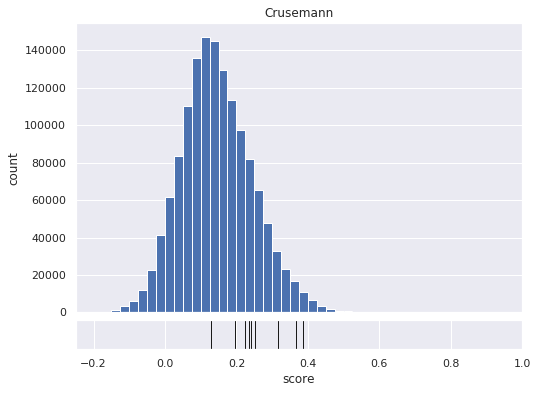

In [190]:
fig = plt.figure(figsize=(8, 6))


# ax_min = -0.15
ax_min = -0.25
# ax_max = 0.35
ax_max = 1.0

gs = gridspec.GridSpec(2, 1, height_ratios=[20, 2], hspace=0.05)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.set_title('Crusemann')

ax1.hist(iokr_scores_all, bins=50, range=[ax_min, ax_max])

ax2.plot(iokr_scores_validated, [5000]*len(iokr_scores_validated), '|', color='k', markersize=50)
ax1.set_xlim([ax_min, ax_max])
ax2.set_xlim([ax_min, ax_max])
ax1.set_xticks([])
ax2.set_yticks([])

ax1.set_ylabel('count')
ax2.set_xlabel('score')

plt.tight_layout()

plt.savefig('combined_iokr_hist_crusemann.pdf')

In [199]:
from nplinker.scoring import misc

In [201]:
strains = npl.strains

In [202]:
test_set_bgc_ids = [x[1] for x in test_set_bgcs]
test_set_spectra_ids = [x[1] for x in test_set_spectra]

iokr_scores_all = []
iokr_scores_validated = []
corr_scores_all = []
corr_scores_validated = []

count = 0
for g in npl.gcfs:
    for m in npl.molfams:
        count += 1
        if count % 1000 == 0:
            print("{} / {}".format(count, len(npl.gcfs) * len(npl.molfams)))
        link_score = -100
        for b in g.bgcs:
            b_idx = test_set_bgc_ids.index(b.name)
            for s in m.spectra:
                s_idx = test_set_spectra_ids.index(s.spectrum_id)
                score = score_matrix[s_idx, b_idx]
                link_score = max(score, link_score)
        iokr_scores_all.append(link_score)
        corr_score = misc.metcalf_scoring(m, g, strains, standardised=True)
        corr_scores_all.append(corr_score)
        # validated
        if (g.id, m.id) in gcf_mf_validated:
            iokr_scores_validated.append(link_score)
            corr_scores_validated.append(corr_score)


1000 / 1404676
2000 / 1404676
3000 / 1404676
4000 / 1404676
5000 / 1404676
6000 / 1404676
7000 / 1404676
8000 / 1404676
9000 / 1404676
10000 / 1404676
11000 / 1404676
12000 / 1404676
13000 / 1404676
14000 / 1404676
15000 / 1404676
16000 / 1404676
17000 / 1404676
18000 / 1404676
19000 / 1404676
20000 / 1404676
21000 / 1404676
22000 / 1404676
23000 / 1404676
24000 / 1404676
25000 / 1404676
26000 / 1404676
27000 / 1404676
28000 / 1404676
29000 / 1404676
30000 / 1404676
31000 / 1404676
32000 / 1404676
33000 / 1404676
34000 / 1404676
35000 / 1404676
36000 / 1404676
37000 / 1404676
38000 / 1404676
39000 / 1404676
40000 / 1404676
41000 / 1404676
42000 / 1404676
43000 / 1404676
44000 / 1404676
45000 / 1404676
46000 / 1404676
47000 / 1404676
48000 / 1404676
49000 / 1404676
50000 / 1404676
51000 / 1404676
52000 / 1404676
53000 / 1404676
54000 / 1404676
55000 / 1404676
56000 / 1404676
57000 / 1404676
58000 / 1404676
59000 / 1404676
60000 / 1404676
61000 / 1404676
62000 / 1404676
63000 / 1404676
6

490000 / 1404676
491000 / 1404676
492000 / 1404676
493000 / 1404676
494000 / 1404676
495000 / 1404676
496000 / 1404676
497000 / 1404676
498000 / 1404676
499000 / 1404676
500000 / 1404676
501000 / 1404676
502000 / 1404676
503000 / 1404676
504000 / 1404676
505000 / 1404676
506000 / 1404676
507000 / 1404676
508000 / 1404676
509000 / 1404676
510000 / 1404676
511000 / 1404676
512000 / 1404676
513000 / 1404676
514000 / 1404676
515000 / 1404676
516000 / 1404676
517000 / 1404676
518000 / 1404676
519000 / 1404676
520000 / 1404676
521000 / 1404676
522000 / 1404676
523000 / 1404676
524000 / 1404676
525000 / 1404676
526000 / 1404676
527000 / 1404676
528000 / 1404676
529000 / 1404676
530000 / 1404676
531000 / 1404676
532000 / 1404676
533000 / 1404676
534000 / 1404676
535000 / 1404676
536000 / 1404676
537000 / 1404676
538000 / 1404676
539000 / 1404676
540000 / 1404676
541000 / 1404676
542000 / 1404676
543000 / 1404676
544000 / 1404676
545000 / 1404676
546000 / 1404676
547000 / 1404676
548000 / 14046

972000 / 1404676
973000 / 1404676
974000 / 1404676
975000 / 1404676
976000 / 1404676
977000 / 1404676
978000 / 1404676
979000 / 1404676
980000 / 1404676
981000 / 1404676
982000 / 1404676
983000 / 1404676
984000 / 1404676
985000 / 1404676
986000 / 1404676
987000 / 1404676
988000 / 1404676
989000 / 1404676
990000 / 1404676
991000 / 1404676
992000 / 1404676
993000 / 1404676
994000 / 1404676
995000 / 1404676
996000 / 1404676
997000 / 1404676
998000 / 1404676
999000 / 1404676
1000000 / 1404676
1001000 / 1404676
1002000 / 1404676
1003000 / 1404676
1004000 / 1404676
1005000 / 1404676
1006000 / 1404676
1007000 / 1404676
1008000 / 1404676
1009000 / 1404676
1010000 / 1404676
1011000 / 1404676
1012000 / 1404676
1013000 / 1404676
1014000 / 1404676
1015000 / 1404676
1016000 / 1404676
1017000 / 1404676
1018000 / 1404676
1019000 / 1404676
1020000 / 1404676
1021000 / 1404676
1022000 / 1404676
1023000 / 1404676
1024000 / 1404676
1025000 / 1404676
1026000 / 1404676
1027000 / 1404676
1028000 / 1404676
10

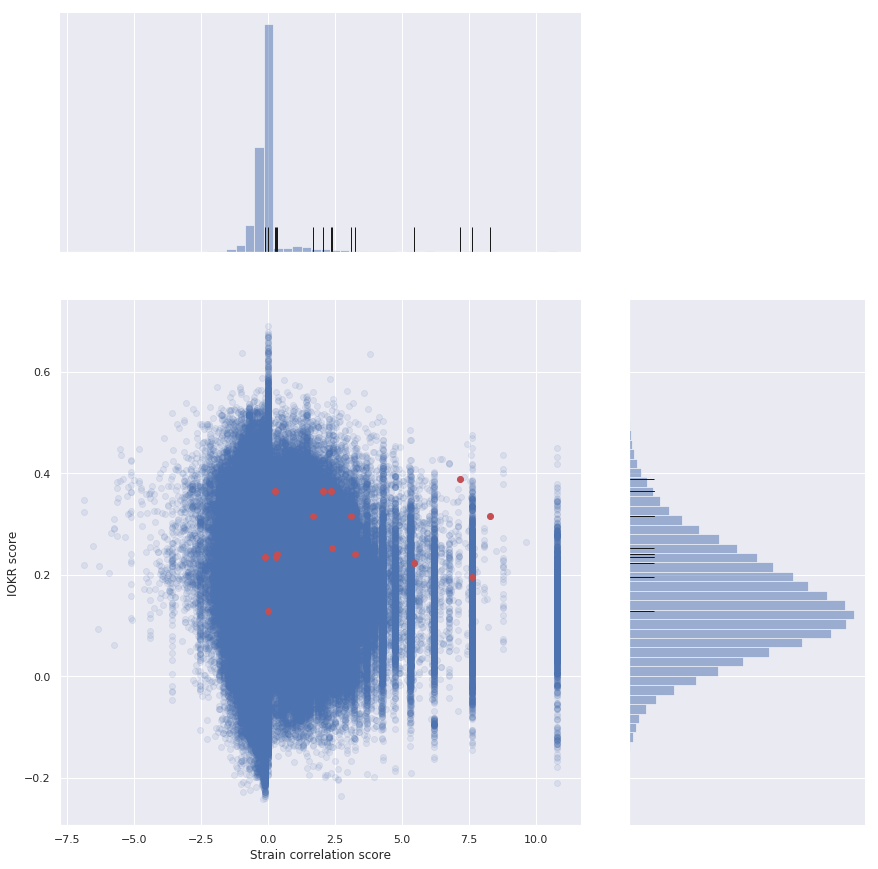

In [216]:
# Fig. for SI

all_score_pairs = list(zip(corr_scores_all, iokr_scores_all))
verified_score_pairs = list(zip(corr_scores_validated, iokr_scores_validated))

col1 = [x[0] for x in all_score_pairs if x[1] != -100]
col2 = [x[1] for x in all_score_pairs if x[1] != -100]


plot = sns.jointplot(col1, col2, alpha=0.1, ratio=2, height=12, marginal_kws={'hist_kws': {'alpha': 0.5}})
plot.ax_joint.plot([x[0] for x in verified_score_pairs if x[1] != -100], [x[1] for x in verified_score_pairs if x[1] != -100], 'ro', color='r')
# bc horizontal, flip x and y axis
plot.ax_marg_y.plot([0]*len(iokr_scores_validated), iokr_scores_validated, '|', color='k', marker=(2, 0, 90), markersize=50)
plot.ax_marg_x.plot(corr_scores_validated, [0]*len(corr_scores_validated), '|', color='k', markersize=50)


#plot.set_axis_labels('Standardised strain correlation score', 'IOKR score', size='large')
plot.set_axis_labels('Strain correlation score', 'IOKR score')


filename = '20210604_graph_combined_data_iokr_metcalf_crusemann'
plot.savefig(filename + '.png') #, dpi=1200)

In [242]:
print(verified_score_pairs)

[(0.2788645161472886, 0.3654975199443822), (0.34909569005526553, 0.2408497451358319), (3.100296637689584, 0.31564877142536085), (-0.11218650701836204, 0.23471866959154875), (2.3793466167370627, 0.3654975199443822), (3.2420501680565126, 0.2408497451358319), (7.61577310586637, 0.19596181195439255), (0.0, 0.12908552278706864), (7.170580248945476, 0.38777003164273616), (8.305367567710885, 0.31606292572303296), (1.7013995762966228, 0.31564877142536085), (0.30867997771552724, 0.23471866959154875), (2.0681324215457253, 0.3654975199443822), (2.396792985472602, 0.25242040528628085), (5.454622241295362, 0.22351401121416692)]


In [215]:
# validated links above percentiles for 90 and 95

In [212]:
percentile_cutoff = 90

all_score_pairs = list(zip(corr_scores_all, iokr_scores_all))
verified_score_pairs = list(zip(corr_scores_validated, iokr_scores_validated))

iokr_percentile = numpy.percentile(iokr_scores_all, percentile_cutoff)
corr_percentile = numpy.percentile(corr_scores_all, percentile_cutoff)

iokr_valid_top = len([x for x in iokr_scores_validated if x > iokr_percentile])
iokr_all_top = len([x for x in iokr_scores_all if x > iokr_percentile])

corr_valid_top = len([x for x in corr_scores_validated if x > corr_percentile])
corr_all_top = len([x for x in corr_scores_all if x > corr_percentile])

both_valid_top = len([x for x, y in verified_score_pairs if x > corr_percentile and y > iokr_percentile])
both_all_top = len([x for x, y in all_score_pairs if x > corr_percentile and y > iokr_percentile])

print('all verified {}'.format(len(verified_score_pairs)))
print('all total {}'.format(len(all_score_pairs)))
print('all ratio {}'.format(len(verified_score_pairs) / len(all_score_pairs)))
print('iokr verified {}'.format(iokr_valid_top))
print('iokr total {}'.format(iokr_all_top))
print('iokr ratio {}'.format(iokr_valid_top / iokr_all_top))
print('corr verified {}'.format(corr_valid_top))
print('corr total {}'.format(corr_all_top))
print('corr ratio {}'.format(corr_valid_top / corr_all_top))
print('both verified {}'.format(both_valid_top))
print('both total {}'.format(both_all_top))
print('both ratio {}'.format(both_valid_top / both_all_top))

all verified 15
all total 1404676
all ratio 1.0678619126403526e-05
iokr verified 7
iokr total 140468
iokr ratio 4.9833414016003645e-05
corr verified 13
corr total 123829
corr ratio 0.00010498348529019858
both verified 7
both total 18538
both ratio 0.000377602761894487


In [213]:
percentile_cutoff = 95

all_score_pairs = list(zip(corr_scores_all, iokr_scores_all))
verified_score_pairs = list(zip(corr_scores_validated, iokr_scores_validated))

iokr_percentile = numpy.percentile(iokr_scores_all, percentile_cutoff)
corr_percentile = numpy.percentile(corr_scores_all, percentile_cutoff)

iokr_valid_top = len([x for x in iokr_scores_validated if x > iokr_percentile])
iokr_all_top = len([x for x in iokr_scores_all if x > iokr_percentile])

corr_valid_top = len([x for x in corr_scores_validated if x > corr_percentile])
corr_all_top = len([x for x in corr_scores_all if x > corr_percentile])

both_valid_top = len([x for x, y in verified_score_pairs if x > corr_percentile and y > iokr_percentile])
both_all_top = len([x for x, y in all_score_pairs if x > corr_percentile and y > iokr_percentile])

print('all verified {}'.format(len(verified_score_pairs)))
print('all total {}'.format(len(all_score_pairs)))
print('all ratio {}'.format(len(verified_score_pairs) / len(all_score_pairs)))
print('iokr verified {}'.format(iokr_valid_top))
print('iokr total {}'.format(iokr_all_top))
print('iokr ratio {}'.format(iokr_valid_top / iokr_all_top))
print('corr verified {}'.format(corr_valid_top))
print('corr total {}'.format(corr_all_top))
print('corr ratio {}'.format(corr_valid_top / corr_all_top))
print('both verified {}'.format(both_valid_top))
print('both total {}'.format(both_all_top))
print('both ratio {}'.format(both_valid_top / both_all_top))

all verified 15
all total 1404676
all ratio 1.0678619126403526e-05
iokr verified 4
iokr total 70234
iokr ratio 5.695247316114702e-05
corr verified 10
corr total 68560
corr ratio 0.00014585764294049007
both verified 3
both total 4895
both ratio 0.0006128702757916241


In [249]:
scores_from_bgc = []
scores_from_bgc_idlist = []

# scores_from_bgc has order (IOKR, std.corr., raw corr)


established_link_objects
established_link_objects_ids

pairs = []
for (bgc, spectrum), (bgc_id, spectrum_id) in zip(established_link_objects, established_link_objects_ids):
    for gcf in npl.gcfs:
        if bgc.id in [x.id for x in gcf.bgcs]:
            for mf in npl.molfams:
                if spectrum.id in [x.id for x in mf.spectra]:
                    if (gcf, mf) not in pairs:
                        pairs.append((gcf, mf))

def get_iokr_score(g, m):
    valid_link_score = -100
    for b in g.bgcs:
        b_idx = test_set_bgc_ids.index(b.name)
        for s in m.spectra:
            s_idx = test_set_spectra_ids.index(s.spectrum_id)
            score = score_matrix[s_idx, b_idx]
            valid_link_score = max(score, valid_link_score)
    return valid_link_score


collected_scores = []
for gcf, mf in pairs:
    valid_corr_score = misc.metcalf_scoring(mf, gcf, strains, standardised=True)
    #print(valid_corr_score)
    valid_iokr_score = get_iokr_score(gcf, mf)
    
    corr_score_list = []
    iokr_score_list = []
    for t_mf in npl.molfams:
        corr_score = misc.metcalf_scoring(t_mf, gcf, strains, standardised=True)
        #print(corr_score)
        corr_score_list.append(corr_score)
        iokr_score = get_iokr_score(gcf, t_mf)
        iokr_score_list.append(iokr_score)
        
    collected_scores.append((gcf, mf, valid_corr_score, corr_score_list, valid_iokr_score, iokr_score_list))
        

    

                        


"""
        link_score = -100
        for b in g.bgcs:
            b_idx = test_set_bgc_ids.index(b.name)
            for s in m.spectra:
                s_idx = test_set_spectra_ids.index(s.spectrum_id)
                score = score_matrix[s_idx, b_idx]
                link_score = max(score, link_score)
"""

"""
for (valid_bgc, valid_mf), mibig_id in zip(verified_bgc_mf_links, verified_bgc_mf_links_labels):
    for gcf in npl.gcfs:
        if valid_bgc.id in [x.id for x in gcf.bgcs]:
            iokr_score_list = []
            metcalf_score_list = []
            raw_metcalf_score_list = []
            for mf in npl.molfams:
                iokr_score = get_iokr_score(mf, gcf)
                iokr_score_list.append(iokr_score)
                raw_metcalf_score = misc.metcalf_scoring(mf, gcf, strains, standardised=False)
                raw_metcalf_score_list.append(raw_metcalf_score)
                metcalf_score = misc.metcalf_scoring(mf, gcf, strains, standardised=True)
                metcalf_score_list.append(metcalf_score)
                if mf == valid_mf:
                    valid_iokr_score = iokr_score
                    valid_metcalf_score = metcalf_score
                    valid_raw_metcalf_score = raw_metcalf_score
            scores_from_bgc.append((
                (iokr_score_list, valid_iokr_score),
                (metcalf_score_list, valid_metcalf_score),
                (raw_metcalf_score_list, valid_raw_metcalf_score)
            ))
                
            scores_from_bgc_idlist.append((gcf, valid_bgc, mibig_id))"""

'\nfor (valid_bgc, valid_mf), mibig_id in zip(verified_bgc_mf_links, verified_bgc_mf_links_labels):\n    for gcf in npl.gcfs:\n        if valid_bgc.id in [x.id for x in gcf.bgcs]:\n            iokr_score_list = []\n            metcalf_score_list = []\n            raw_metcalf_score_list = []\n            for mf in npl.molfams:\n                iokr_score = get_iokr_score(mf, gcf)\n                iokr_score_list.append(iokr_score)\n                raw_metcalf_score = misc.metcalf_scoring(mf, gcf, strains, standardised=False)\n                raw_metcalf_score_list.append(raw_metcalf_score)\n                metcalf_score = misc.metcalf_scoring(mf, gcf, strains, standardised=True)\n                metcalf_score_list.append(metcalf_score)\n                if mf == valid_mf:\n                    valid_iokr_score = iokr_score\n                    valid_metcalf_score = metcalf_score\n                    valid_raw_metcalf_score = raw_metcalf_score\n            scores_from_bgc.append((\n       

In [250]:
def l_p(x, y, p):
    return numpy.sign(x) * numpy.power(numpy.abs(x), p) + numpy.sign(y) * numpy.power(numpy.abs(y), p)

l_p(1, 2, 0.5)

2.414213562373095

In [255]:
# 11: retimycin, 14: lomaiviticin
results = []

for gcf, mf, actual_score_metcalf, score_set_metcalf, actual_score_iokr, score_set_iokr in collected_scores:
    # print('retimycin A, BGC0001228')
    total = len(score_set_metcalf)
    higher_corr = len([x for x in score_set_metcalf if x >= actual_score_metcalf])
    higher_both = len([x for x, y in zip(score_set_iokr, score_set_metcalf) if y >= actual_score_metcalf and x >= actual_score_iokr])
    higher_iokr = len([x for x in score_set_iokr if x >= actual_score_iokr])


    iokr_mean = numpy.mean(iokr_scores_all)
    iokr_std = numpy.std(iokr_scores_all)
    score_set_iokr_std = (score_set_iokr - iokr_mean) / iokr_std
    actual_score_iokr_std = (actual_score_iokr - iokr_mean) / iokr_std
    
    sum_scores = [l_p(x, y, 0.5) for x, y in zip(score_set_iokr_std, score_set_metcalf)]
    sum_scores.sort(reverse=True)
    rank_index_12 = len([x for x in sum_scores if x >= l_p(actual_score_iokr_std, actual_score_metcalf, 0.5)])
    
    sum_scores = [l_p(x, y, 2) for x, y in zip(score_set_iokr_std, score_set_metcalf)]
    sum_scores.sort(reverse=True)
    rank_index_2 = len([x for x in sum_scores if x >= l_p(actual_score_iokr_std, actual_score_metcalf, 2)])
    
    sum_scores = [l_p(x, y, 1) for x, y in zip(score_set_iokr_std, score_set_metcalf)]
    sum_scores.sort(reverse=True)
    rank_index_1 = len([x for x in sum_scores if x >= l_p(actual_score_iokr_std, actual_score_metcalf, 1)])

    results.append((gcf.id, mf.family_id, total, higher_iokr, higher_corr, rank_index_12, rank_index_1, rank_index_2, higher_both))

In [256]:
for r in results:
    print(r)

(71, 353, 3094, 130, 16, 7, 6, 9, 4)
(333, 353, 3094, 130, 189, 41, 51, 169, 17)
(71, 358, 3094, 475, 1968, 889, 853, 904, 293)
(333, 358, 3094, 473, 612, 301, 524, 774, 117)
(48, 353, 3094, 79, 287, 129, 154, 166, 15)
(123, 353, 3094, 79, 126, 47, 88, 115, 8)
(367, 353, 3094, 80, 216, 25, 37, 99, 9)
(48, 358, 3094, 628, 282, 198, 451, 701, 94)
(123, 358, 3094, 614, 101, 73, 97, 108, 28)
(367, 358, 3094, 526, 90, 71, 92, 138, 20)
(132, 489, 3094, 1069, 25, 23, 11, 11, 10)
(161, 492, 3094, 1774, 1152, 1680, 1699, 1726, 629)
(232, 206, 3094, 74, 1, 1, 1, 1, 1)
(295, 309, 3094, 149, 7, 3, 3, 7, 3)
(377, 381, 3094, 642, 16, 19, 17, 17, 9)


In [254]:
mf.family_id

381